In [1]:
#import all the necessary packages
import numpy as np #for numerical array data
import pandas as pd #for tabular data
from scipy.optimize import minimize
import matplotlib.pyplot as plt #for plotting purposes
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#import cvxpy as cp # 2020 update: cannot import cvxpy. Perhaps update later...
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from statsmodels import api as sm
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

from pandas.plotting import register_matplotlib_converters # Required
register_matplotlib_converters()

import seaborn as sns
sns.set()

In [2]:
# Dataset

# Change the file path to your own directory
file_path = '~/Desktop/python_2018/Datasets/'

life_table = pd.read_csv(file_path + 'Life_expectancy.csv')
# Social Security Fund analysis
SS_data = pd.read_csv(file_path + 'SS_simulation.csv',index_col=0, header=0,parse_dates=[0])
# Asset returns (with regimes)
asset_data_raw = pd.read_csv(file_path + 'AssetData.csv',index_col=0, header=0,parse_dates=[0])
macro_data_raw = pd.read_csv(file_path + 'MacroData.csv',index_col=0, header=0,parse_dates=[0])
SP500_data = pd.read_csv(file_path + 'SP500_CPI.csv',index_col=0, header=0,parse_dates=[0])

In [3]:
# Factor Momentum data from Daniel
asset_data_new = pd.read_csv(file_path + 'AssetData_FM.csv',index_col=0, header=0,parse_dates=[0])
assetname_new = ['US Equities','EAFE Equities', 'EM Equities', 'US Treasuries',
       'Corp Bonds', 'TIPS', 'Real Estate', 'CSMOMPos', 'T-bill']
Assets_new = asset_data_new[assetname_new].values
asset_data_MOM = Assets_new[~np.isnan(Assets_new[:,2]),:]

In [4]:
asset_data_raw.shape

(405, 17)

In [5]:
asset_data_raw.columns

Index(['World Equities', 'US Treasuries', 'High Yield ',
       'Inflation Protection', 'Currency Protection', 'Regime-5', 'Regime-7',
       'Regime-NBER', 'US Equities', 'EAFE Equities', 'EM Equities',
       'LongTreasuries', 'Corp Bonds', 'TIPS(backfilled)', 'Real Estate',
       'Commodities', 'T-bill'],
      dtype='object')

#### A brief note about asset data
Note: the "LongTreasuries" data contains long-term treasuries only. 

For retire analysis we prefer the "US Treasuries" data. 

The "asset_retire" object in section 3 reflects this preference.

In [7]:
factorname = ['World Equities','US Treasuries','High Yield ','Inflation Protection','Currency Protection']
Factors = asset_data_raw[factorname].values
assetname = ['US Equities','EAFE Equities', 'EM Equities', 'LongTreasuries',
       'Corp Bonds', 'TIPS(backfilled)', 'Real Estate', 'Commodities', 'T-bill']
Assets = asset_data_raw[assetname].values
Regime = asset_data_raw['Regime-7'].values

In [8]:
asset_data_MOM.shape

(369, 9)

In [9]:
# Some missing data 
factor_data = Factors[~np.isnan(Assets[:,2]),:]
asset_data = Assets[~np.isnan(Assets[:,2]),:]
regime_data = Regime[~np.isnan(Assets[:,2])]

In [10]:
np.sum(regime_data==1), np.sum(regime_data==-1)

(316, 53)

In [11]:
# Factor works with less correlation
np.corrcoef(factor_data.T),np.corrcoef(factor_data[regime_data==1,:].T),np.corrcoef(factor_data[regime_data!=1,:].T)

(array([[ 1.        , -0.10200368,  0.54731296,  0.07990946, -0.55939834],
        [-0.10200368,  1.        , -0.04147495, -0.28248422, -0.08493527],
        [ 0.54731296, -0.04147495,  1.        ,  0.17053819, -0.23748187],
        [ 0.07990946, -0.28248422,  0.17053819,  1.        , -0.15165623],
        [-0.55939834, -0.08493527, -0.23748187, -0.15165623,  1.        ]]),
 array([[ 1.        , -0.0396799 ,  0.44988018, -0.0231314 , -0.5752664 ],
        [-0.0396799 ,  1.        ,  0.1094371 , -0.26981547, -0.0598487 ],
        [ 0.44988018,  0.1094371 ,  1.        , -0.00474358, -0.21609858],
        [-0.0231314 , -0.26981547, -0.00474358,  1.        , -0.07619496],
        [-0.5752664 , -0.0598487 , -0.21609858, -0.07619496,  1.        ]]),
 array([[ 1.        , -0.11822239,  0.59381472,  0.37446243, -0.58539329],
        [-0.11822239,  1.        , -0.20563139, -0.33472957, -0.21607693],
        [ 0.59381472, -0.20563139,  1.        ,  0.52914875, -0.29726967],
        [ 0.37446243,

In [12]:
factor_data.mean(axis=0)

array([0.00601311, 0.00478238, 0.00692699, 0.00017678, 0.00031191])

In [13]:
# Some Functions
def portfolio_opt(mu, Q, r_bar):
    w = cp.Variable(mu.size)
    ret = mu.T*w 
    risk = cp.quad_form(w, Q)
    prob = cp.Problem(cp.Minimize(risk), 
                   [cp.sum(w) == 1, w >= 0, ret >= r_bar])
    prob.solve()
    return np.round_(w.value,decimals=3)

# EWMA covariance?
def ewma_cov(x1, x2, smoothing_factor):
    # x1, x2 are two series    
    n = len(x1)
    weights = np.array([smoothing_factor**(n-i-1) for i in range(n)])
    return np.sum(weights*x1*x2*(1-smoothing_factor)/(1-smoothing_factor**n))

def ewma_mat(A, smoothing_factor = 0.99):
    # A: asset data (time*asset_num)
    mu = A.mean(axis=0)
    m,n = A.shape
    cov = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            cov[i,j] = ewma_cov(A[:,i]-mu[i],A[:,j]-mu[j],smoothing_factor)
    return cov
    
def cov_corr(A):
    x,y = A.shape
    if x != y:
        return A*0
    else:
        B = np.ones((x,y))
        for i in range(x):
            for j in range(x):
                B[i,j] = A[i,j] / np.sqrt(A[i,i]*A[j,j])
    return B

def geo_mean(x):
    n = len(x)
    return np.exp(np.sum(np.log(1+x)) * 12 / n)-1

def geo_return(X, input_type='Return'):
    """Computes geometric return for each asset"""
    if input_type == 'Return':
        X_geo = 1+X
        y = np.cumprod(X_geo,axis=0)
        return (y[-1,:]) ** (1/X.shape[0]) - 1
    else:
        return (X[-1,:] / X[0,:]) ** (1/(X.shape[0]-1)) - 1

Note to the smoothing factor:

    0.99 -> 30% for data 10 years ago, 2.7% for data 30 years ago
    
    0.995 -> 55% for data 10 years ago, 16.5% for data 30 years ago
    
    0.9975 -> 74% for data 10 years ago, 40.6% for data 30 years ago
    
    0.999 -> 70% for data 30 years ago

In [14]:
[np.apply_along_axis(geo_mean,0,factor_data[regime_data==1,:])*100,
np.apply_along_axis(geo_mean,0,factor_data[regime_data==-1,:])*100]

[array([15.11676036,  4.88744602, 12.42500969,  0.07933711, -0.41621094]),
 array([-3.55562895e+01,  1.13242757e+01, -1.35976746e+01,  4.03504981e-03,
         3.41417727e+00])]

In [15]:
[np.apply_along_axis(geo_mean,0,asset_data[regime_data==1,-1])*100,
np.apply_along_axis(geo_mean,0,asset_data[regime_data==-1,-1])*100]

[3.1558279193480976, 2.9255807344771068]

In [16]:
print(asset_data_raw.columns[-9:])
np.apply_along_axis(geo_mean,0,asset_data)

Index(['US Equities', 'EAFE Equities', 'EM Equities', 'LongTreasuries',
       'Corp Bonds', 'TIPS(backfilled)', 'Real Estate', 'Commodities',
       'T-bill'],
      dtype='object')


array([0.10828302, 0.05781744, 0.10784523, 0.07819485, 0.06897254,
       0.05931434, 0.09589508, 0.03318138, 0.03122726])

In [17]:
asset_data_cleared = np.nan_to_num(asset_data_raw)

regime_result = pd.DataFrame(index=['Mean','STD','Mean-Normal','STD-Normal','Mean-Crash','STD-Crash'], 
                    columns=asset_data_raw.columns)

regime_result.iloc[0,:] = np.apply_along_axis(geo_mean,0,asset_data_cleared)
regime_result.iloc[1,:] = np.apply_along_axis(np.std,0,asset_data_cleared)
regime_result.iloc[2,:] = np.apply_along_axis(geo_mean,0,asset_data_cleared[Regime==1,:])
regime_result.iloc[3,:] = np.apply_along_axis(np.std,0,asset_data_cleared[Regime==1,:])
regime_result.iloc[4,:] = np.apply_along_axis(geo_mean,0,asset_data_cleared[Regime==-1,:])
regime_result.iloc[5,:] = np.apply_along_axis(np.std,0,asset_data_cleared[Regime==-1,:])

#regime_result.to_csv('regime_0905.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


## 1. Regime-based Asset Data

In [18]:
###
# Use "regime-7". Already verified by previous regime analysis...
###

In [19]:
# Data imported
# SP500_data = pd.read_csv(file_path + 'SP500_CPI.csv',index_col=0, header=0,parse_dates=[0])
SP500_data.tail()

,CPI,SP500,SP500TR,Wil5000
DATE,,,,
2018-05-01,251.588,2648.05,5318.100098,123.71
2018-06-01,251.989,2705.27,5350.830078,127.18
2018-07-01,252.006,2718.37,5549.959961,128.11
2018-08-01,252.146,2816.29,5730.799805,132.31
2018-09-01,252.439,2901.52,5763.419922,137.04


In [20]:
CPI_deflator = np.insert(SP500_data.loc[asset_data_raw.index,'CPI'].values[~np.isnan(Assets[:,2])],0,115.4)

In [21]:
CPI_series = 1 + np.diff(CPI_deflator) / CPI_deflator[:-1]

asset_data_def = (1+asset_data) / np.concatenate([CPI_series.reshape(-1,1)]*9, axis=1) - 1

In [22]:
np.apply_along_axis(geo_mean,0,asset_data_def)

array([0.08042687, 0.03122971, 0.08000008, 0.05109494, 0.04210443,
       0.03268899, 0.06835028, 0.00721286, 0.00530786])

In [23]:
list_cov = [np.cov(asset_data.T),
           np.cov(asset_data[regime_data==1,:].T),
           np.cov(asset_data[regime_data!=1,:].T),
           ewma_mat(asset_data),
           ewma_mat(asset_data[regime_data==1,:]),
           ewma_mat(asset_data[regime_data!=1,:]),
           ewma_mat(asset_data, .995),
           ewma_mat(asset_data[regime_data==1,:],.995),
           ewma_mat(asset_data[regime_data!=1,:],.995),
           ewma_mat(asset_data_def),
           ewma_mat(asset_data_def[regime_data==1,:]),
           ewma_mat(asset_data_def[regime_data!=1,:]),]
#np.savetxt("cov_0718.csv", 10000*np.concatenate(list_cov), delimiter=",")

In [24]:
list_corr = [cov_corr(A) for A in list_cov]

#np.savetxt("corr_0718.csv", np.concatenate(list_corr), delimiter=",")

## 2. Factor Model

In [30]:
def linear_regression(x,y):
    lin_reg = LinearRegression(fit_intercept=True)
    lin_reg.fit(x,y)
    return lin_reg.intercept_, lin_reg.coef_

def cv_LASSO(x,y,n_folds = 5, alpha_max=0.25/500):    
    LASSO_test = Lasso(random_state=777, fit_intercept=True)
    alphas = np.linspace(1e-6, alpha_max, 100)

    tuned_parameters = [{'alpha': alphas}]
    
    clf = GridSearchCV(LASSO_test, tuned_parameters, cv=n_folds, refit=False) 
    clf.fit(x,y)

    alpha_best = alphas[np.argmax(clf.cv_results_['mean_test_score'])]
    LASSO_best = Lasso(alpha=alpha_best, fit_intercept=True)
    LASSO_best.fit(x,y)
    return LASSO_best.intercept_, LASSO_best.coef_

def best_subset(x,y,l_0):
    # Mixed Integer Programming in feature selection
    M = 10
    _, n_factor = x.shape
    z = cp.Variable(n_factor, boolean=True)
    beta = cp.Variable(n_factor)
    alpha = cp.Variable(1)

    def MIP_obj(x,y,b,a):
        return cp.norm(y-cp.matmul(x,b)-a,2)

    best_subset = cp.Problem(cp.Minimize(MIP_obj(x, y, beta, alpha)), 
                             [cp.sum(z)<=l_0, beta+M*z>=0, M*z>=beta])
    best_subset.solve()
    return alpha.value, beta.value

def oos_error(a,b,x,y,method):
    # a, b are one-dimensional array
    error = np.linalg.norm(y-x.dot(b)-a)
    print('The out-of-sample error of ' + method + ' is: {0:3f}\n'.format(error))
    
def error_analysis(x,y,x2,y2):
    a1, b1 = linear_regression(x,y)
    a2, b2 = cv_LASSO(x,y)
    a3, b3 = best_subset(x,y,3)
    a4, b4 = best_subset(x,y,2)
    oos_error(a1,b1,x2,y2,'OLS')
    oos_error(a4,b4,x2,y2,'best 2-subset')
    oos_error(a3,b3,x2,y2,'best 3-subset')
    oos_error(a2,b2,x2,y2,'LASSO')
    return a2, b2

def error_analysis_complete(X,Y,colnames, oos_ratio=0.9):
    # Y: asset data with column names 
    n_time, n_factor = X.shape
    _, n_asset = Y.shape
    
    n_is = int(n_time*oos_ratio)
    X_test = X[:n_is,:]
    X_oos = X[n_is:,:]
    
    betas_LASSO = np.zeros((n_factor+1,n_asset))
    
    for i in range(n_asset):
        print('For asset: ' + colnames[i] + '\n')
        y_test = Y[:n_is,i]
        y_oos = Y[n_is:,i]
        a,b = error_analysis(X_test,y_test,X_oos,y_oos)
        betas_LASSO[0,i] = a*100
        betas_LASSO[1:,i] = b
        
    return pd.DataFrame(np.round_(betas_LASSO, decimals=1), index=['Intercept (\%)']+factorname, 
                        columns=assetname, dtype=None, copy=False)

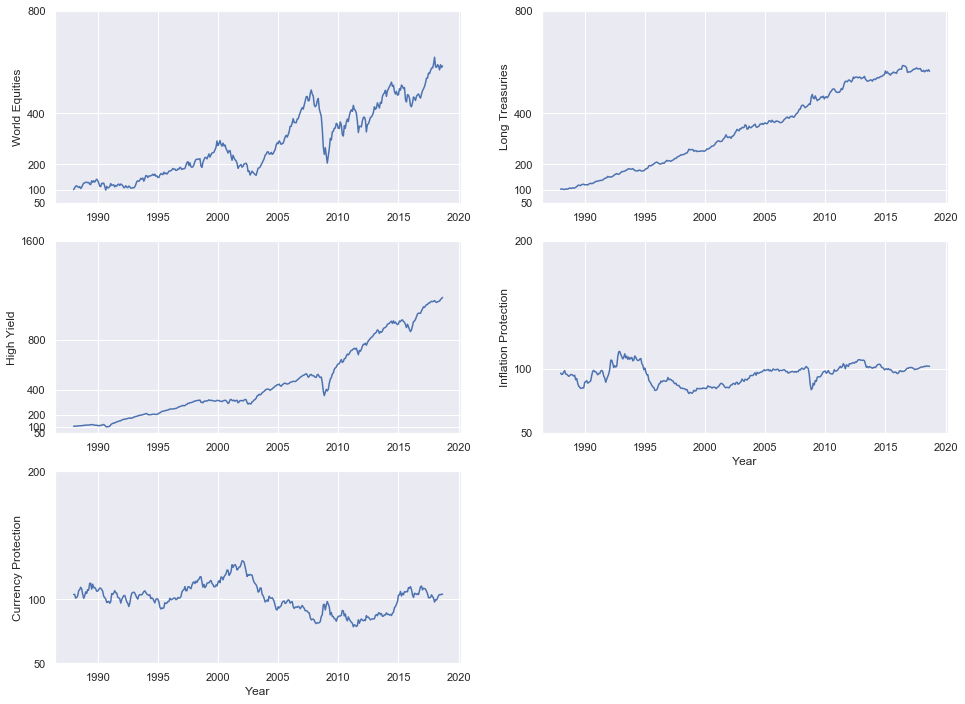

In [26]:
# Plotting the factors
fig = plt.figure(1, figsize=(16,12))
x_time = np.arange(1988,2018.75,1/12)

plt.subplot(321)
plt.plot(x_time, 100*np.cumprod(1+factor_data[:,0]), 'b-')
plt.ylabel('World Equities')
plt.ylim([50, 500])
plt.yticks([50, 100, 200, 400, 800],[50, 100, 200, 400, 800])

plt.subplot(322)
plt.plot(x_time, 100*np.cumprod(1+factor_data[:,1]), 'b-')
plt.ylabel('Long Treasuries')
plt.ylim([50, 500])
plt.yticks([50, 100, 200, 400, 800],[50, 100, 200, 400, 800])

plt.subplot(323)
plt.plot(x_time, 100*np.cumprod(1+factor_data[:,2]), 'b-')
plt.ylabel('High Yield')
plt.ylim([50, 500])
plt.yticks([50, 100, 200, 400, 800, 1600],[50, 100, 200, 400, 800, 1600])

plt.subplot(324)
plt.plot(x_time, 100*np.cumprod(1+factor_data[:,3]), 'b-')
plt.xlabel('Year')
plt.ylabel('Inflation Protection')
plt.ylim([50, 200])
plt.yticks([50, 100, 200],[50, 100, 200])

plt.subplot(325)
plt.plot(x_time, 100*np.cumprod(1+factor_data[:,4]), 'b-')
plt.xlabel('Year')
plt.ylabel('Currency Protection')
plt.ylim([50, 200])
plt.yticks([50, 100, 200],[50, 100, 200])

plt.show()

In [32]:
# Out-of-sample Error Analysis for Factor Models
# Will give error. Perhaps try later...
import cvxpy as cp
loadings_all = error_analysis_complete(factor_data,asset_data,colnames=assetname)
loadings_all

ModuleNotFoundError: No module named 'cvxpy'

In [121]:
# Out-of-sample Error Analysis for Factor Models, regime-based

# Here is previous result for reference

asset_pd = pd.DataFrame(asset_data, columns=assetname)
loadings_n = error_analysis_complete(factor_data[regime_data==1,:],asset_data[regime_data==1,:])
loadings_c = error_analysis_complete(factor_data[regime_data!=1,:],asset_data[regime_data!=1,:])

For asset: US Equities



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.115220

The out-of-sample error of best 2-subset is: 0.114064

The out-of-sample error of best 3-subset is: 0.113338

The out-of-sample error of LASSO is: 0.114275

For asset: EAFE Equities

The out-of-sample error of OLS is: 0.012072

The out-of-sample error of best 2-subset is: 0.012472

The out-of-sample error of best 3-subset is: 0.012262

The out-of-sample error of LASSO is: 0.012260

For asset: EM Equities



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.164375

The out-of-sample error of best 2-subset is: 0.144975

The out-of-sample error of best 3-subset is: 0.143182

The out-of-sample error of LASSO is: 0.164028

For asset: Long Treasuries



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.062735

The out-of-sample error of best 2-subset is: 0.063686

The out-of-sample error of best 3-subset is: 0.063086

The out-of-sample error of LASSO is: 0.063591

For asset: Corp Bonds



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.025067

The out-of-sample error of best 2-subset is: 0.026065

The out-of-sample error of best 3-subset is: 0.025066

The out-of-sample error of LASSO is: 0.025705

For asset: TIPS



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.000002

The out-of-sample error of best 2-subset is: 0.000002

The out-of-sample error of best 3-subset is: 0.000002

The out-of-sample error of LASSO is: 0.000484

For asset: Real Estate



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.171245

The out-of-sample error of best 2-subset is: 0.177609

The out-of-sample error of best 3-subset is: 0.179572

The out-of-sample error of LASSO is: 0.177287

For asset: Commodities



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.235408

The out-of-sample error of best 2-subset is: 0.242485

The out-of-sample error of best 3-subset is: 0.236958

The out-of-sample error of LASSO is: 0.232217

For asset: T-bill



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.010757

The out-of-sample error of best 2-subset is: 0.010865

The out-of-sample error of best 3-subset is: 0.010802

The out-of-sample error of LASSO is: 0.011572

For asset: US Equities



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.072517

The out-of-sample error of best 2-subset is: 0.071354

The out-of-sample error of best 3-subset is: 0.071852

The out-of-sample error of LASSO is: 0.073215

For asset: EAFE Equities

The out-of-sample error of OLS is: 0.009266

The out-of-sample error of best 2-subset is: 0.010119

The out-of-sample error of best 3-subset is: 0.009385

The out-of-sample error of LASSO is: 0.009277

For asset: EM Equities



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.065787

The out-of-sample error of best 2-subset is: 0.070231

The out-of-sample error of best 3-subset is: 0.067209

The out-of-sample error of LASSO is: 0.071802

For asset: Long Treasuries



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.084790

The out-of-sample error of best 2-subset is: 0.086919

The out-of-sample error of best 3-subset is: 0.086360

The out-of-sample error of LASSO is: 0.090110

For asset: Corp Bonds



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.011730

The out-of-sample error of best 2-subset is: 0.014551

The out-of-sample error of best 3-subset is: 0.012148

The out-of-sample error of LASSO is: 0.013751

For asset: TIPS



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.000001

The out-of-sample error of best 2-subset is: 0.000001

The out-of-sample error of best 3-subset is: 0.000001

The out-of-sample error of LASSO is: 0.000227

For asset: Real Estate



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.188236

The out-of-sample error of best 2-subset is: 0.200710

The out-of-sample error of best 3-subset is: 0.179108

The out-of-sample error of LASSO is: 0.186107

For asset: Commodities



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The out-of-sample error of OLS is: 0.105290

The out-of-sample error of best 2-subset is: 0.083305

The out-of-sample error of best 3-subset is: 0.084167

The out-of-sample error of LASSO is: 0.094049

For asset: T-bill

The out-of-sample error of OLS is: 0.005983

The out-of-sample error of best 2-subset is: 0.006143

The out-of-sample error of best 3-subset is: 0.005909

The out-of-sample error of LASSO is: 0.006489



/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## 3. Asset Simulation

In [33]:
# It is always better to construct a class...
class asset_simulation:
    """
    Defines a full regime-based asset simulation class.
    
    Variables:
        asset_data: contains asset return information. 
        asset_data_type: 'TR'=total return index, 'LogRet'=log returns, 'ARet'=arithmatic returns
        regime_data: contains information for regime analysis. Should be 3 columns: Date, Return and Total Return Index
        regime: 'SP500' by default. (More careful plotting for SP500, but can do others)
        beta: fitted values for trend-filtering algorithm, or we can manually give some data (e.g. NBER dates)
    
    Settings:
        random_seed: for reproducible codes
        n_scenarios: number of scenarios to generate
        beta_threshold: for trend-filtering algorithm
        freq: data frequency. Will support quarterly in the future.
        
    Methods:
        
        trend_filtering: runs the algorithm with a certain value of lambda.
        filter_plot: plot original series vs fitted series.
             
    """
    def __init__(self, ad, adt, reg, reg_name='SP500'):
        self.asset_data = ad
        self.n_hist, self.n_asset = ad.shape
        self.asset_data_type = adt
        self.regime_data = reg
        self.regime_type = reg_name
        self.beta = 0
        self.regime = 0
        self.mu_n = 0
        self.mu_c = 0
        self.Q_n = 0
        self.Q_c = 0
        self.change_settings()
        
    def change_settings(self, random_seed=777, n_scenarios=10000, n_years=50, freq=12, beta_threshold=1e-6):
        self.random_seed = random_seed
        self.n_scenarios = n_scenarios
        self.n_years = n_years
        self.freq = freq
        self.beta_threshold = beta_threshold
    
    def trend_filtering(self, lambda_value):
        '''Runs trend-filtering algorithm to separate regimes.
        '''
        data = self.regime_data.values[:,0]
        n = np.size(data)
        x_ret = data.reshape(n)

        Dfull = np.diag([1]*n) - np.diag([1]*(n-1),1)
        D = Dfull[0:(n-1),]
        
        import cvxpy as cp
        beta = cp.Variable(n)
        lambd = cp.Parameter(nonneg=True)

        def tf_obj(x,beta,lambd):
            return cp.norm(x-beta,2)**2 + lambd*cp.norm(cp.matmul(D, beta),1)

        problem = cp.Problem(cp.Minimize(tf_obj(x_ret, beta, lambd)))

        lambd.value = lambda_value
        problem.solve()
        
        self.beta = beta.value # Update
        self.regime = np.sign(self.beta-self.beta_threshold)

    def transition_matrix(self):
        """Computes the transition matrix given the regime vector
        """
        regime = self.regime
        n1,n2,n3,n4 = 0,0,0,0
        for i in range(len(regime)-1):
            if regime[i] == 1:
                if regime[i+1] == 1:
                    n1 += 1
                else:
                    n2 += 1
            else:
                if regime[i+1] == 1:
                    n3 += 1
                else:
                    n4 += 1
        return n1/(n1+n2), n2/(n1+n2), n3/(n3+n4), n4/(n3+n4)

    def filter_plot(self, lambda_value):
        ret_sp = self.regime_data.iloc[:,1]
        self.trend_filtering(lambda_value)
        beta_pd = pd.Series(self.beta,index=self.regime_data.index)

        plt.figure(figsize=(12,9))
        plt.plot(ret_sp, alpha=0.4,label='Original Series')
        plt.plot(beta_pd,label='Fitted Series')
        plt.xlabel('Year')
        plt.ylabel('Monthly Return (%)')
        plt.legend(loc='upper right')
        plt.show()

    def regime_switch(self):
        '''returns list of starting points of each regime'''
        n = len(self.beta)
        init_points = [0]
        curr_reg = (self.beta[0]>self.beta_threshold)
        for i in range(n):
            if (self.beta[i]>self.beta_threshold) == (not curr_reg):
                curr_reg = not curr_reg
                init_points.append(i)
        init_points.append(n)
        return init_points

    def plot_regime_color(dataset, regime_num=0, TR_num=1, lambda_value=16, log_TR = True):
        '''
        Plot of return series versus regime
        ---> Needs some work on this. Maybe later...
        '''
        returns = dataset.iloc[:,regime_num]
        TR = dataset.iloc[:,TR_num]
        betas = trend_filtering(returns.values,lambda_value)
        regimelist = regime_switch(betas)
        curr_reg = np.sign(betas[0]-1e-5)
        y_max = np.max(TR) + 500

        if log_TR:
            fig, ax = plt.subplots()
            for i in range(len(regimelist)-1):
                if curr_reg == 1:
                    ax.axhspan(0, y_max+500, xmin=regimelist[i]/regimelist[-1], 
                               xmax=regimelist[i+1]/regimelist[-1], facecolor='green', alpha=0.3)
                else:
                    ax.axhspan(0, y_max+500, xmin=regimelist[i]/regimelist[-1], 
                               xmax=regimelist[i+1]/regimelist[-1], facecolor='red', alpha=0.5)
                curr_reg = -1 * curr_reg

            fig.set_size_inches(12,9)   
            plt.plot(TR, label='Total Return')
            plt.ylabel('SP500 Log-scale')
            plt.xlabel('Year')
            plt.yscale('log')
            plt.xlim([dataset.index[0], dataset.index[-1]])
            plt.ylim([80, 3000])
            plt.yticks([100, 500, 1000, 2000, 3000],[100, 500, 1000, 2000, 3000])
            plt.title('Regime Plot of SP 500', fontsize=24)
            plt.show()

    def regime_return(self):
        """Computes returns of a list of regime columns identified by number"""
        
        ret_n = self.asset_data.values[self.regime==1, :]
        ret_c = self.asset_data.values[self.regime==-1, :]
        self.mu_n = geo_return(ret_n)
        self.mu_c = geo_return(ret_c)
        self.Q_n = np.cov(ret_n.T)
        self.Q_c = np.cov(ret_c.T)
        
    def regime_asset(self,n,mu1,mu2,Q1,Q2,p1,p2):
        s_1 = np.random.multivariate_normal(mu1, Q1, n).T
        s_2 = np.random.multivariate_normal(mu2, Q2, n).T
        regime = np.ones(n)
        for i in range(n-1):
            if regime[i] == 1:
                if np.random.rand() > p1:
                    regime[i+1] = 0
            else:
                if np.random.rand() > p2:
                    regime[i+1] = 0
        return (regime*s_1 + (1-regime)*s_2).T

    
    def regime_simulation(self):
        """
        Simulates regime-based monthly returns.
        Returns a (n_year*12) * n_asset * n_scenario tensor for all asset information.
        """
        p1, _, p2, _ = self.transition_matrix()

        r_all = np.zeros((self.n_years*12, self.n_asset, self.n_scenarios))

        np.random.seed(self.random_seed)
        for i in range(self.n_scenarios):
            r_all[:,:,i] = self.regime_asset(self.n_years*self.freq,
                                        self.mu_n,self.mu_c,self.Q_n,self.Q_c,p1,p2)
        return r_all

    def regime_simulation_cut(self,lower,upper):
        """
        Simulates regime-based monthly returns.
        Returns a (n_year*12) * n_asset * n_scenario tensor for all asset information.
        """
        p1, _, p2, _ = self.transition_matrix()

        r_all = np.zeros((self.n_years*12, self.n_asset, self.n_scenarios))
        
        np.random.seed(self.random_seed)
        i = 0
        while r_all[0,0,-1] == 0:
            r_temp = self.regime_asset(self.n_years*self.freq,
                                        self.mu_n,self.mu_c,self.Q_n,self.Q_c,p1,p2)
            us_eq_sim = r_temp[:,0] + 1
            ann_ret_simu = (np.cumprod(us_eq_sim)[-1]) ** (1/self.n_years)
            if ann_ret_simu > lower and ann_ret_simu < upper:
                r_all[:,:,i] = r_temp
                i = i + 1
        return r_all
    
    def print_result(self):
        s1 = np.sqrt(12*np.diag(self.Q_n))
        s2 = np.sqrt(12*np.diag(self.Q_c))
        info = np.vstack((self.mu_n,s1,self.mu_c,s2))
        
        return pd.DataFrame(info, index=['Mean-Normal','STDEV-Normal','Mean-Crash','STDEV-Crash'], 
                            columns=self.asset_data.columns)

In [34]:
asset_pd = pd.DataFrame(asset_data, columns=assetname)

asset_retire = asset_simulation(asset_pd, 'ARet', SP500_data)
asset_retire.regime = regime_data
asset_retire.regime_return()
asset_retire.random_seed = 777

In [35]:
asset_retire2 = asset_simulation(asset_pd, 'ARet', SP500_data)
asset_retire2.regime = regime_data
asset_retire2.regime_return()

In [36]:
# Compare with NBER regime, data updated
asset_data_NBER = pd.read_csv(file_path + 'AssetData.csv',index_col=0, header=0,parse_dates=[0])
regime_NBER = asset_data_NBER['Regime-NBER'].values[36:]
asset_retire2.regime = regime_NBER
asset_retire2.regime_return()
asset_retire2.print_result().to_csv('regime_NBER.csv')

In [37]:
np.sqrt(np.diag(asset_retire.Q_c))

array([0.06080395, 0.06758166, 0.08840257, 0.03820389, 0.02143111,
       0.02154047, 0.10438683, 0.08776086, 0.00194877])

In [38]:
asset_data_retire = asset_data.copy()
asset_data_retire[:,3] = factor_data[:,1]

asset_retire.mu_n = np.array([1.06,1,1.2,0.2,0.42,0.25,1.05,0.68,0.2])/100
asset_retire.mu_c = np.array([-2.21,-2.5,-2.87,0.8,0.46,0.8,-2.07,-1.21,0.2])/100
asset_retire.Q_n = ewma_mat(asset_data_retire[regime_data==1,:],.995)
asset_retire.Q_c = ewma_mat(asset_data_retire[regime_data!=1,:],.995)

In [39]:
asset_retire.n_scenarios = 10000
r_all_50 = asset_retire.regime_simulation()
# Test annualized return
(1+np.mean(np.mean(r_all_50,axis=0),axis=1))**12

array([1.07395706, 1.06228154, 1.07741078, 1.03469729, 1.05221018,
       1.04002355, 1.07522203, 1.05090309, 1.02425629])

In [40]:
us_eq_sim = r_all_50[:,0,:]

ann_ret_simu = (np.cumprod(1+us_eq_sim,axis=0)[-1,:]) ** (1/50)

print(ann_ret_simu.mean(),ann_ret_simu.std())

1.0633328398292599 0.03313819304528493


### Truncate the simulated numbers so that the equity return is between 4.5% and 8.5%

In [41]:
asset_retire.n_scenarios = 10000
r_all_cut = asset_retire.regime_simulation_cut(1.045,1.085)
(1+np.mean(np.mean(r_all_cut,axis=0),axis=1))**12

array([1.07621528, 1.06460248, 1.08027367, 1.03441866, 1.05241546,
       1.0399386 , 1.07844666, 1.05244575, 1.02427346])

1.065275538021011 0.011319818838214273


(array([758., 762., 776., 864., 919., 841., 889., 834., 842., 874., 837.,
        804.]),
 array([1.04500331, 1.04833619, 1.05166907, 1.05500195, 1.05833484,
        1.06166772, 1.0650006 , 1.06833348, 1.07166636, 1.07499924,
        1.07833212, 1.081665  , 1.08499788]),
 <a list of 12 Patch objects>)

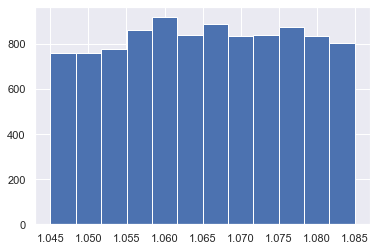

In [42]:
us_eq_cut = r_all_cut[:,0,:]

ann_ret_cut = (np.cumprod(1+us_eq_cut,axis=0)[-1,:]) ** (1/50)
print(ann_ret_cut.mean(),ann_ret_cut.std())
plt.hist(ann_ret_cut, bins=12)

In [43]:
# A few sanity checks
for i in range(9):
    
    ann_temp = (np.cumprod(1+r_all_cut[:,i,:],axis=0)[-1,:]) ** (1/50)
    print(ann_temp.mean(),ann_temp.std())

1.065275538021011 0.011319818838214273
1.050813772212351 0.01910111695115402
1.055372772710317 0.02650947837634803
1.033497803394401 0.006566829721970086
1.0510694687089062 0.007443573087236374
1.0383301524644455 0.008591565243483413
1.0570609006289415 0.025743509513831874
1.029449645286481 0.030037657769141406
1.0242476890692886 0.001031149151126838


In [44]:
for i in range(9):
    ann_temp = (np.cumprod(1+r_all_cut[:,i,:],axis=0)[-1,:]) ** (1/50)
    print(np.cumprod(ann_temp)[-1]**(1/10000)-1)

0.06521538052990872
0.05064011989430717
0.055039940255698694
0.03347694344242136
0.05104311565306219
0.038294611182043914
0.05674730755945445
0.029011224252869727
0.024247170021732822


In [45]:
for i in range(9):
    print(r_all_cut[:,i,:].reshape(-1,1).mean())
    #print(r_all_cut[:,i,:].reshape(-1,1).std())

0.006139646931594848
0.005230420629914153
0.006455279905541812
0.002823945853700027
0.004266405448309616
0.003268803947837429
0.0063133232251022285
0.0042688141992408436
0.0020006273317399862


In [46]:
#asset_retire.print_result().to_csv('simulation_0718.csv')

## Factor Momentum - September

Notes: here are the last piece of simulations I ran. Skip to section 4 first, then return here for more functionalities.

In [487]:
asset_pd_new = pd.DataFrame(asset_data_MOM, columns=assetname_new)

asset_MOMsim = asset_simulation(asset_pd_new, 'ARet', SP500_data)
asset_MOMsim.regime = regime_data
asset_MOMsim.regime_return()
asset_MOMsim.random_seed = 777

In [488]:
asset_MOMsim.mu_n, asset_MOMsim.mu_c

(array([0.01600942, 0.01161624, 0.01711782, 0.00398439, 0.00593464,
        0.00409761, 0.01333648, 0.00351802, 0.00259257]),
 array([-0.03443902, -0.03559967, -0.04091554,  0.00897984,  0.00342393,
         0.0090915 , -0.02552978,  0.0197463 ,  0.00240589]))

In [553]:
# "High" Settings - 9/5/19 newest estimates

asset_MOMsim.mu_n = np.array([1.63,1.40,2.04,0.2,0.42,0.25,1.30,0.25,0.2])/100
asset_MOMsim.mu_c = np.array([-3.38,-3.93,-4.16,0.7,0.3,0.6,-1.96,0.75,0.2])/100
asset_MOMsim.Q_n = ewma_mat(asset_data_MOM[regime_data==1,:],.995)
asset_MOMsim.Q_c = ewma_mat(asset_data_MOM[regime_data!=1,:],.995)

In [554]:
asset_MOMsim.n_scenarios = 10000
r_all_MOM = asset_MOMsim.regime_simulation()
# Test annualized return
(1+np.mean(np.mean(r_all_MOM,axis=0),axis=1))**12

array([1.11616948, 1.08004106, 1.14890594, 1.03299139, 1.049391  ,
       1.03658597, 1.10508645, 1.03911074, 1.02425698])

In [555]:
r_all_MOMcut = asset_MOMsim.regime_simulation_cut(1.06,1.15)
# Test annualized return
(1+np.mean(np.mean(r_all_MOMcut,axis=0),axis=1))**12

array([1.1185723 , 1.08284557, 1.15240014, 1.03271317, 1.049487  ,
       1.03650341, 1.10710074, 1.0387671 , 1.02426744])

In [568]:
r_all_MOMcut.shape

(600, 9, 10000)

In [556]:
# Compare..
(1+np.mean(np.mean(r_all_cut,axis=0),axis=1))**12

array([1.07621528, 1.06460248, 1.08027367, 1.03441866, 1.05241546,
       1.0399386 , 1.0751206 , 1.05244575, 1.02427346])

In [526]:
# Old
#_, _, report_MOM2 = simulation_savings_MOM(hold_vec_MOM,r_all_MOMcut+1,saving_rate=0.10,init_salary=132900)
#report_MOM2.to_csv('report0830_s10w13.csv')

#_, _, report_MOM4 = simulation_savings_MOM(hold_vec_MOM,r_all_MOMcut+1,saving_rate=0.08,init_salary=132900)
#report_MOM4.to_csv('report0830_s8w13.csv')

_, _, report_MOM3 = simulation_savings_MOM(hold_vec_MOM,r_all_MOMcut+1,saving_rate=0.08,init_salary=200000)
report_MOM3.to_csv('report0830_s8w20.csv')

_, _, report_MOM5 = simulation_savings_MOM(hold_vec_MOM,r_all_MOMcut+1,saving_rate=0.10,init_salary=200000)
report_MOM5.to_csv('report0830_s10w20.csv')

In [534]:
# New test - Aug 29 - US DEV EM TREA CORP TIPS REITS (MOM) TBILL
hold_vec = np.array([[0, 0, 0, 0.3, 0.3, 0.3, 0, 0, 0.1], # Bonds
                    [0.4, 0.1, 0.2, 0.1, 0, 0.1, 0.1, 0, 0], # "60-40" - 80% equities in fact
                     [0.45, 0.05, 0.25, 0.05, 0, 0.05, 0.15, 0, 0], # SGP - 90% equity first
                    [0.15, 0.0125, 0.05, 0.25, 0, 0.5, 0.0375, 0, 0]]) # RGP - 25% equity first, 90% equity last

hold_vec_MOM = np.array([[0, 0, 0, 0.3, 0.3, 0.3, 0, 0, 0.1], # Bonds
                    [0.4, 0.1, 0.2, 0.1, 0, 0.1, 0.1, 0, 0], # "60-40" - 80% equities in fact
                     [0.45, 0.05, 0.25, 0.05, 0, 0.05, 0.15, 0, 0], # SGP - 90% equity first
                    [0.15, 0.0125, 0.05, 0.25, 0, 0.5, 0.0375, 0, 0]]) # RGP - 25% equity first, 90% equity last

# High settings
R_mat = 1 + r_all_MOMcut
savings = [0.06, 0.07, 0.08, 0.09, 0.10]
report_MOM1 = simulation_savings_full(hold_vec_MOM,R_mat,savings,MOM=False,sex='F',init_salary=132900)
report_MOM1.to_csv('report0904_w13F.csv')

report_MOM2 = simulation_savings_full(hold_vec_MOM,R_mat,savings,MOM=True,sex='F',init_salary=132900)
report_MOM2.to_csv('report0904_MOMw13F.csv')

In [540]:
# Original Settings
R_mat = 1 + r_all_cut
savings = [0.08, 0.10, 0.12, 0.13, 0.15]
simulation_savings_full(hold_vec_MOM,R_mat,savings,1.055,False,sex='F',init_salary=132900).to_csv('report0905_w13F_low.csv')
simulation_savings_full(hold_vec_MOM,R_mat,savings,1.055,False,sex='F',init_salary=200000).to_csv('report0905_w20F_low.csv')
simulation_savings_full(hold_vec_MOM,R_mat,savings,1.055,False,sex='M',init_salary=200000).to_csv('report0905_w20M_low.csv')

In [557]:
# High Settings - Sep 5 Results
R_mat = 1 + r_all_MOMcut
savings = [0.06, 0.07, 0.08, 0.09, 0.10, 0.12]
simulation_savings_full(hold_vec_MOM,R_mat,savings,1.08,False,sex='F',init_salary=132900).to_csv('report0905_w13F_high.csv')
simulation_savings_full(hold_vec_MOM,R_mat,savings,1.08,True,sex='F',init_salary=132900).to_csv('report0905_w13F_highMOM.csv')

In [546]:
# US DEV EM TREA CORP TIPS REITS (MOM) TBILL, annualized
(1+asset_MOMsim.mu_n)**12, (1+asset_MOMsim.mu_c)**12

(array([1.18295818, 1.15389462, 1.23289241, 1.02426577, 1.04406571,
        1.03041596, 1.13758223, 1.03041596, 1.02426577]),
 array([0.76383648, 0.79050144, 0.74346666, 1.07442417, 1.0390831 ,
        1.07442417, 0.92584651, 1.0938069 , 1.02426577]))

In [597]:
# Historical Settings?
def create_history_return(r, n_s, m=600, block_size=60):
    """
    Simulates n_s scenarios, each containing m historical (block) datapoints from r (p*n_asset*n_s)
    For now, we assume m is a multiply of 60 (i.e. 5 years).
    """
    n_month, n_asset = r.shape
    data = np.zeros((m, n_asset, n_s))
    for i in range(n_s):
        # stopping criteria
        for j in range(int(m/block_size)):
            max_month = n_month - block_size
            temp_index = int(np.random.rand()*max_month)
            data[(j*block_size):(j*block_size+block_size),:,i] = r[temp_index:(temp_index+block_size),:]
    return data

In [603]:
r_all_hist = create_history_return(asset_data_MOM, n_s=10000)
(1+np.mean(np.mean(r_all_hist,axis=0),axis=1))**12

array([1.11263641, 1.07237262, 1.12023873, 1.06062392, 1.07132084,
       1.06419568, 1.12783106, 1.0842682 , 1.0296367 ])

MOM simulated: array([1.1185723 , 1.08284557, 1.15240014, 1.03271317, 1.049487  ,
       1.03650341, 1.10710074, 1.0387671 , 1.02426744])

In [604]:
R_mat = 1 + r_all_hist
savings = [0.06, 0.07, 0.08, 0.09, 0.10]
report_hist1 = simulation_savings_full(hold_vec_MOM,R_mat,savings,MOM=False,sex='F',init_salary=132900)
report_hist1.to_csv('report0909_hist_w13F.csv')

report_hist2 = simulation_savings_full(hold_vec_MOM,R_mat,savings,MOM=True,sex='F',init_salary=132900)
report_hist2.to_csv('report0909_hist_MOMw13F.csv')

### New Functions - Added functions for momentum strategies

In [529]:
def personal_retire_simulation_MOM(person, initial_amount, savings_rate, holdings, asset_return, 
                                   hold_type, high_growth=1.09, sl=-1.0):
    """Simulates monthly data of a person for a certain number of years.
    
    Assets: US equity, developed, emerging, US Treasuries, corp bonds, TIPS, Real Estate, Factor Momentum, T-bill
    Equity (Y/N): Y      Y          Y             N            N        N        Y             (Overlay)        N
    
    asset_return should be total return, i.e. 1 plus the percentage return.
    holding strategy is "ZoneSave" with extra savings going into Factor Momentum
    
    sl is the slope for glide path (SGP: -1, RGP: 1.5)
    
    Other data required:
        inf_mat, ir_mat, COLA_mat: the macro variables simulated
        
    The simulation returns a full path of wealth at the end of each year, so it is a n_scenarios*n_years matrix.
    """
    n_months, n_assets, n_scenarios = asset_return.shape
    wealth_path = np.zeros((n_scenarios, int(n_months/12)))
    eq_set = [0,1,2,6]
    bd_set = [3,4,5,8]
    factorMOM = 0.0 # Total Factor Momentum Savings
    equity_prop = np.sum(holdings[eq_set]) * 100
    
    savings = savings_rate * person.init_wage
    total_saved = initial_amount
    
    # Compute safe-vec and wealth-vec
    for i in range(n_scenarios):
        n_years = person.retire-person.age-1
        wealth_vec = np.ones(55)*(np.median(person.wealth_needed))
        wealth_growth = high_growth
        for n in range(n_years+1):
            wealth_vec[n_years-n] = (wealth_vec[n_years+1-n] - savings * inf_mat[i,n]) / wealth_growth

        safe_growth = 1.02
        safe_vec = np.ones(55) * (np.mean(person.wealth_needed) + 2*np.std(person.wealth_needed))
        for n in range(n_years+1):
            safe_vec[n_years-n] = (safe_vec[n_years+1-n] - savings * inf_mat[i,n]) / safe_growth

    if hold_type == 'fixed':
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
        return wealth_path

    elif type(hold_type)==int:
        ## this integer is rebalance frequency
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%hold_type == 0: # Rebalance
                    asset_temp = np.sum(holdings_each)
                    holdings_each = asset_temp * holdings
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path

    elif hold_type == 'SGP':
        ## Gliding path: slope is given
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    holdings_each[eq_set] = holdings_each[eq_set] * (equity_prop + sl*(j+1)/12) / equity_prop
                    holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_prop - sl*(j+1)/12) / (100-equity_prop)                
        return wealth_path

    elif hold_type == 'RGP':
        ## Gliding path: reversed
        if np.abs(np.sum(holdings[eq_set])-0.25) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    holdings_each[eq_set] = holdings_each[eq_set] * (equity_prop + sl*(j+1)/12) / equity_prop
                    holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_prop - sl*(j+1)/12) / (100-equity_prop) 
                    #if i == 7777: 
                    #Test:print([sum(holdings_each), holdings_each[0]])                    
        return wealth_path 
    
    elif hold_type == 'Dynamic-GP':
        ## Gliding path, same as SGP but tries to catch up when falling behind
        
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = 0.0
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
              
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    
                    if wealth_path[i,int(j/12)] >= wealth_vec[int(j/12)+1]:
                        equity_newprop = equity_prop + sl*(j+1)/12
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                    else:
                        equity_newprop = min(equity_prop + sl*(j+1)/12 + 20, 95)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag = n_flag + 1
        return n_flag/n_scenarios, wealth_path
    
    elif hold_type == 'Safe-play':
        ## Gliding path, same as SGP but switches to bonds when safe
                                             
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = 0.0
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
                
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings

                    if wealth_path[i,int(j/12)] <= safe_vec[int(j/12)+1]:
                        equity_newprop = equity_prop + sl*(j+1)/12
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                    else:
                        equity_newprop = max(equity_prop + sl*(j+1)/12 - 50, 5)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag = n_flag + 1
        return n_flag/n_scenarios, wealth_path
    
    elif hold_type == 'Zone':
        ## Similar to the idea of 'No-Trade Zone', we have "No-change Zone"
        ## Works for both SGP-zone and RGP-zone
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001 and np.abs(np.sum(holdings[eq_set])-0.25) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = [0,0]
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    
                    if wealth_path[i,int(j/12)] <= wealth_vec[int(j/12)+1]:
                        # lagging
                        equity_newprop = min(equity_prop + sl*(j+1)/12 +20, 95)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag[0] = n_flag[0] + 1.0/n_scenarios
                        
                    elif wealth_path[i,int(j/12)] >= safe_vec[int(j/12)+1]:
                        equity_newprop = max(equity_prop + sl*(j+1)/12 -50, 5)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag[1] = n_flag[1] + 1.0/n_scenarios
                    else:
                        equity_newprop = equity_prop + sl*(j+1)/12
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
        return n_flag, wealth_path

    elif hold_type == 'ZoneSave':
        ## We save more (thus rebalancing the portfolio) when trailing
        ## Works for both SGP and RGP
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001 and np.abs(np.sum(holdings[eq_set])-0.25) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = [0,0]
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                                      
                    if wealth_path[i,int(j/12)] <= wealth_vec[int(j/12)+1]:
                        # lagging
                        wealth_path[i,int(j/12)] = wealth_path[i,int(j/12)] + 0.03*savings/savings_rate*inf_mat[i,int(j/12)]
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        equity_newprop = min(equity_prop + sl*(j+1)/12 +20, 95)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag[0] = n_flag[0] + 1.0/n_scenarios
                        
                    elif wealth_path[i,int(j/12)] >= safe_vec[int(j/12)+1]:
                        equity_newprop = max(equity_prop + sl*(j+1)/12 -50, 5)
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag[1] = n_flag[1] + 1.0/n_scenarios
                    else:
                        equity_newprop = equity_prop + sl*(j+1)/12
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
        return n_flag, wealth_path
    
    else:
        ## "ZoneSave" that Works for both SGP and RGP
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001 and np.abs(np.sum(holdings[eq_set])-0.25) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = [0,0]

        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount

            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]

                    if wealth_path[i,int(j/12)] <= wealth_vec[int(j/12)+1]:
                        # lagging
                        factorMOM = holdings_each[7]
                        factorMOM = factorMOM + 0.03*savings/savings_rate*inf_mat[i,int(j/12)]
                        holdings_each = (wealth_path[i,int(j/12)]-holdings_each[7]) * holdings
                        equity_newprop = min(equity_prop + sl*(j+1)/12 +20, 95)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        holdings_each[7] = factorMOM
                        n_flag[0] = n_flag[0] + 1.0/n_scenarios

                    elif wealth_path[i,int(j/12)] >= safe_vec[int(j/12)+1]:
                        equity_newprop = max(equity_prop + sl*(j+1)/12 -50, 5)
                        factorMOM = holdings_each[7]
                        holdings_each = (wealth_path[i,int(j/12)]-holdings_each[7]) * holdings
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        holdings_each[7] = factorMOM
                        n_flag[1] = n_flag[1] + 1.0/n_scenarios
                    else:
                        equity_newprop = equity_prop + sl*(j+1)/12
                        factorMOM = holdings_each[7]
                        holdings_each = (wealth_path[i,int(j/12)]-holdings_each[7]) * holdings
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        holdings_each[7] = factorMOM
            #print(safe_vec)
            #print(wealth_vec)
        return n_flag, wealth_path

In [539]:
def simulation_savings_full(h_M,R,savings,e_g=1.09,MOM=True,
                            retire_age=69, FRA=69, sex='F',init_salary=132900,n_simulation=10000):
    """
    R: total return vector (1+arithmetic return)
    savings: vector for saving rates
    """
    
    mat_simulation = []
    mat_people = []
    report = pd.DataFrame()
    
    for saving_rate in savings:

        title = 'save '+str(int(saving_rate*100))+'%'
        strats=['60-40','Bonds','Target Date','Reversed Glide Path','Dynamic-CatchUp','Dynamic-Safe',
                'Dynamic-Zone','Dynamic-ZoneSave','Reversed-Zone','Reversed-ZoneSave']

        # Extra savings type
        savetype = 'ZoneSaveMOM' if MOM else 'ZoneSave'
        
        h = int(n_simulation * 0.05-1)
        list_simulation = []
        list_people = []
        
        for i in [0.6,0.7,0.8,0.9]: 
            list_people.append(PersonalRetirement(25, retire_age, FRA, sex, init_salary, i, n_simulation, life_table))     

        for P in list_people:
            subtitle = title + ', Goal ' + str(int(P.salary_proportion*100)) +'%'
            P.wealth_comp(ir_mat, inf_mat, COLA_mat)
            results_1 = personal_retire_simulation_MOM(P, 0.01, saving_rate, h_M[1,:], R[:,:,:n_simulation], 'fixed') 
            results_2 = personal_retire_simulation_MOM(P, 0.01, saving_rate, h_M[0,:], R[:,:,:n_simulation], 'fixed') 
            results_3 = personal_retire_simulation_MOM(P, 0.01, saving_rate, h_M[2,:], R[:,:,:n_simulation], 'SGP')
            results_4 = personal_retire_simulation_MOM(P, 0.01, saving_rate, h_M[3,:], R[:,:,:n_simulation], 'RGP', 
                                                       sl=1.5)
            n_flag5,results_5 = personal_retire_simulation_MOM(P, 0.01, saving_rate, h_M[2,:], R[:,:,:n_simulation], 
                                                               'Dynamic-GP',high_growth=e_g)
            n_flag6,results_6 = personal_retire_simulation_MOM(P, 0.01, saving_rate, h_M[2,:], R[:,:,:n_simulation], 
                                                               'Safe-play',high_growth=e_g)
            n_flag7,results_7 = personal_retire_simulation_MOM(P, 0.01, saving_rate, h_M[2,:], R[:,:,:n_simulation], 
                                                               'Zone',high_growth=e_g) 
            n_flag8,results_8 = personal_retire_simulation_MOM(P, 0.01, saving_rate, h_M[2,:], R[:,:,:n_simulation], 
                                                               savetype,high_growth=e_g)
            n_flag9,results_9 = personal_retire_simulation_MOM(P, 0.01, saving_rate, h_M[3,:], R[:,:,:n_simulation], 
                                                               'Zone', high_growth=e_g, sl=1.5) 
            n_flag10,results_10 = personal_retire_simulation_MOM(P, 0.01, saving_rate, h_M[3,:], R[:,:,:n_simulation],
                                                                 savetype, high_growth=e_g, sl=1.5)

            simu_list = [results_1,results_2,results_3,results_4,results_5,
                         results_6,results_7,results_8,results_9,results_10]

            report_list = pd.DataFrame(columns=strats, index=[subtitle,'Median Wealth', 'Probability', 'Goal-at-Risk', 
                                                   'Conditional Goal-at-Risk', '% Falling Behind', '%Safe',' '])
            for j, r in enumerate(simu_list):
                temp_amount = np.sort(P.wealth_needed-r[:,43])
                temp_arr = np.array([np.median(r[:,43]),np.mean(temp_amount<0), 
                                     temp_amount[-h], np.mean(temp_amount[-h:])])          
                report_list.iloc[1:5,j] = temp_arr

            report_list.iloc[5,[4,6,7,8,9]] = [n_flag5/50,n_flag7[0]/50,n_flag8[0]/50,n_flag9[0]/50,n_flag10[0]/50]
            report_list.iloc[6,[5,6,7,8,9]] = [n_flag6/50,n_flag7[1]/50,n_flag8[1]/50,n_flag9[1]/50,n_flag10[1]/50]
            report_list.fillna('',inplace=True)
            report = report.append(report_list)
            list_simulation.append(simu_list)
            
        mat_simulation.append(list_simulation)
        mat_people.append(list_people)
        
    # mat_simulation, mat_people is for testing only
    return report

## 4. Retirement Simulation

In [150]:
class Person:
    """Defines a person (group) for general simulation
    variables:
        age: current age
        retire: retirement age, should not exceed 72
        full_retire: Full Retirement Age (FRA), the age at which 100% benefit is guaranteed
        sex: 'M' or 'F'
    methods:
        total_cont: computes total (discounted) contribution of the person
        
    """
    def __init__(self, age, retire, full_retire, sex):
        self.age = age
        self.retire = min(retire, 72)
        self.full_retire = full_retire
        self.sex = sex
        
    def total_cont(self, tax, benefit, life_table, inf_cum, ir_cum, cola_cum, n_people, death_reduce):
        """
        Simulates total contribution of a group of n_people.
        Length of inf_cum and ir_cum should be 100.
        death_reduce is estimated reduce in death rate.
        """    
        age = self.age
        retire = self.retire
        years_togo = retire - age
        yearly_contribution = np.zeros(len(inf_cum)) # no more than 100
        people_alive = n_people
        survivor_benefit = np.zeros(100) # a vector of people in the benefit, starting from retirement age
        # Early penalty / Late benefit
        if retire >= self.full_retire:
            benefit = benefit * (1+0.08*(retire-self.full_retire))
        else:
            benefit = benefit * (1-0.066*(retire-self.full_retire))
        
        if self.sex == 'M':
            for i in range(years_togo):
                people_died = int(people_alive * life_table['Probability_M'][int(age+i)] * ((1-death_reduce)**i))
                people_alive = people_alive - people_died
                yearly_contribution[i] = people_alive * tax * inf_cum[i]
                
                if i>=10: # Have survivor benefit
                    survivor_benefit[:15] = survivor_benefit[:15] + people_died * .75
                
                if i==years_togo-1: # Test purpose
                    a = yearly_contribution[i]

            for i in range(retire,120):
                people_died = int(people_alive * life_table['Probability_M'][int(i)] * ((1-death_reduce)**(i-age))) 
                people_alive = people_alive - people_died
                # Survivor benefit
                l = int(i-retire)
                u = int(i+max(4, 99-i)/2-retire)   # At least 1 year, but at most 15 years
                survivor_benefit[l:u] = survivor_benefit[l:u] + people_died * .75
                
                yearly_contribution[i-age] = (0-people_alive-survivor_benefit[l]) * benefit * cola_cum[i-age]
                #print(people_alive)
                #print(survivor_benefit)
                if i==retire:
                    b = -yearly_contribution[i-age]

        else:
            for i in range(years_togo):
                people_died = int(people_alive * life_table['Probability_F'][int(age+i)] * ((1-death_reduce)**i))
                people_alive = people_alive - people_died
                yearly_contribution[i] = people_alive * tax * inf_cum[i]
                
                if i>=10: # Have survivor benefit
                    survivor_benefit[:15] = survivor_benefit[:15] + people_died / 3
                
                if i==years_togo-1: # Test purpose
                    a = yearly_contribution[i]

            for i in range(retire,120):
                people_died = int(people_alive * life_table['Probability_F'][int(i)] * ((1-death_reduce)**(i-age))) 
                people_alive = people_alive - people_died
                # Survivor benefit
                l = int(i-retire)
                u = int(i+max(4, 99-i)/2-retire)   # At least 1 year, but at most 15 years
                survivor_benefit[l:u] = survivor_benefit[l:u] + people_died / 3
                
                yearly_contribution[i-age] = (0-people_alive-survivor_benefit[l]) * benefit * cola_cum[i-age]
                
                if i==retire:
                    b = -yearly_contribution[i-age]
        
        #print(people_alive)
        return yearly_contribution / ir_cum

Text(0.5, 0, 'Years')

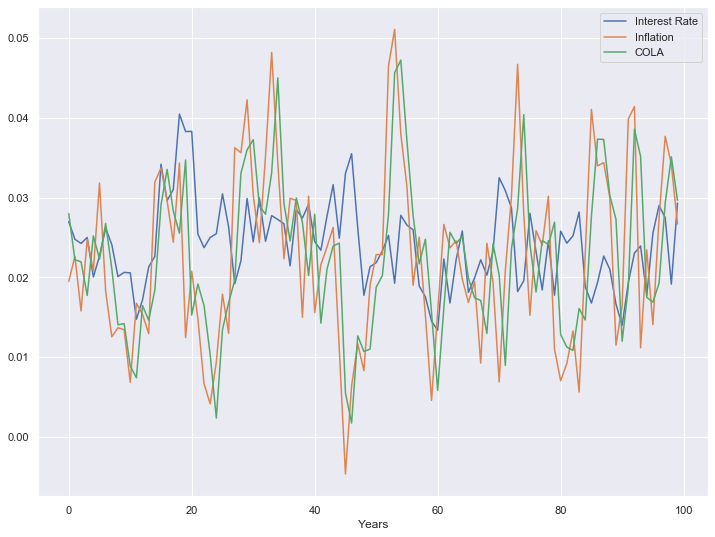

In [456]:
# Mean-reverting
n_years = 100
interest_vec = np.ones(n_years) * 1.027
inflation_vec = np.ones(n_years) * 1.0195
COLA_vec = np.ones(n_years) * 1.028

mu_int = 1.024
mu_inf = 1.022 # theta and sigma adjusted in codes below

np.random.seed(888) # Test = 888, good indicator

for i in range(n_years-1):
    interest_vec[i+1] = interest_vec[i] + 0.5*(mu_int-interest_vec[i]) + 0.004*np.sqrt(interest_vec[i])*randn(1)
    if interest_vec[i+1]<=0: # No negative rate
        interest_vec[i+1] = 0
    inflation_vec[i+1] = inflation_vec[i] + 0.5*(mu_inf-inflation_vec[i]) + 0.01*randn(1)
#    if i==0: #Complicated way to simulate COLA...
#        COLA_vec[i+1] = 0.05*inflation_vec[i+1] + 0.8*inflation_vec[i] + 0.12*interest_vec[i] + 0.002*randn(1)
#    else:
#        COLA_vec[i+1] = COLA_vec[i] + 0.05*(inflation_vec[i+1]-inflation_vec[i]) + 0.8*(
#            inflation_vec[i]-inflation_vec[i-1])+ 0.12*(interest_vec[i+1]-interest_vec[i]) + 0.002*randn(1)
    COLA_vec[i+1] = 0.1*inflation_vec[i+1] + 0.8*inflation_vec[i] + 0.1*interest_vec[i] + 0.002*randn(1)
    if COLA_vec[i+1]<=0:
        COLA_vec[i] = 0
        
plt.figure(figsize=(12,9))
plt.plot(interest_vec-1,label='Interest Rate')
plt.plot(inflation_vec-1, label='Inflation')
plt.plot(COLA_vec-1,label='COLA')
plt.legend(loc='best')
plt.xlabel('Years')

In [152]:
# Macro variables
n_simulation = 10000
inf_mat = np.zeros((n_simulation, n_years))
ir_mat = np.zeros((n_simulation, n_years))
COLA_mat = np.zeros((n_simulation, n_years))
TIPS_mat = np.zeros((n_simulation, n_years))

mu_int = 1.024
mu_inf = 1.022 # theta and sigma adjusted in codes below

for j in range(n_simulation):
    np.random.seed(j)
    interest_vec = np.ones(n_years) * 1.027
    inflation_vec = np.ones(n_years) * 1.0195
    COLA_vec = np.ones(n_years) * 1.028
    for i in range(n_years-1):
        interest_vec[i+1] = interest_vec[i] + 0.5*(mu_int-interest_vec[i]) + 0.004*np.sqrt(interest_vec[i])*randn(1)
        if interest_vec[i+1]<=0: # No negative rate
            interest_vec[i+1] = 0
        inflation_vec[i+1] = inflation_vec[i] + 0.5*(mu_inf-inflation_vec[i]) + 0.01*randn(1)
        COLA_vec[i+1] = 0.1*inflation_vec[i+1] + 0.8*inflation_vec[i] + 0.1*interest_vec[i] + 0.002*randn(1)
        if COLA_vec[i+1]<=0:
            COLA_vec[i] = 0
    TIPS_vec = inflation_vec + 0.5/100
    inf_mat[j,:] = np.cumprod(inflation_vec)
    ir_mat[j,:] = np.cumprod(interest_vec)
    COLA_mat[j,:] = np.cumprod(COLA_vec)
    TIPS_mat[j,:] = np.cumprod(TIPS_vec)

In [307]:
class PersonalRetirement(Person):
    """
    Simulates the SS and 401(k) accounts for a person.
    
    Variables (Person):
        age: current age
        retire: retirement age, should not exceed 72
        full_retire: Full Retirement Age (FRA), the age at which 100% benefit is guaranteed
        sex: 'M' or 'F'
        init_wage: initial wage (in million dollars)
        
    Variables (Retirement):
        salary_proportion: The goal in terms of proportions
        savings: list of possible savings
        strategy_vec: currently available strategies...
        wealth_list: list of results for each strategy: len(strategy_vec) of "n_scenarios * len(savings)" arrays
        n_scenarios: number of scenarios
        survive_prob: survival probability, starting from retirement age
        wealth_needed: Goal in each
        
    Methods:
        wealth_comp: Compute wealth needed in each scenario
        risk_report: Outputs wealth needed, probability of reaching goal, GaR, CGaR
    """

    def __init__(self, age, retire, full_retire, sex, init_wage, goal, n_scenarios, life_table):
        self.salary_proportion = goal
        self.init_wage = init_wage / 1e6
        self.strategy_vec = []
        self.wealth_list = []
        self.n_scenarios = n_scenarios
        Person.__init__(self, age, retire, full_retire, sex)
        
        life_table_adj = life_table['Probability_'+sex].copy()
        self.survive_prob = np.ones(120-int(retire))
        death_reduce = .65/100 if sex=='M' else .85/100
        
        for i in range(int(retire),119):
            life_table_adj[i] = life_table_adj[i] * ((1-death_reduce)**(i-25))
            self.survive_prob[i-int(retire)+1] = self.survive_prob[i-int(retire)]* (1-life_table_adj[i])
            
        self.savings = ['8%','9%','10%','11%','12%','13%','14%','15%']

    
    def wealth_comp(self, ir_mat, inf_mat, COLA_mat, test_pay=34332):
        """
        test_pay: current maximum benefit amount
        """
        total_required = np.zeros(self.n_scenarios)
        ir_init = int(self.retire-self.age)
        for i in range(self.n_scenarios):
            ir_deflator = ir_mat[i, ir_init:95] / ir_mat[i, ir_init]
            sum_needed = np.sum(self.init_wage * self.survive_prob * inf_mat[i, ir_init:95] * 
                                self.salary_proportion / ir_deflator)
            if self.init_wage >= 0.1329:
                sum_ss = np.sum(test_pay/1e6 * self.survive_prob * COLA_mat[i, ir_init:95] / ir_deflator)
            else:
                test_pay = test_pay * self.init_wage / 132900
                sum_ss = np.sum(test_pay * self.survive_prob * COLA_mat[i, ir_init:95] / ir_deflator)
            total_required[i] = sum_needed - sum_ss
        self.wealth_needed = total_required
    
    def prob_calc(self):
        if self.strategy_vec == []:
            return 0
        index_list = []
        prob_matrix = np.zeros((len(self.strategy_vec),len(self.savings)))
        for i, name in enumerate(self.strategy_vec):
            index_list.append(name+', '+str(self.salary_proportion*100)+'%')
            for j in range(len(self.savings)):
                prob_matrix[i,j] = np.sum(self.wealth_list[i][:,j] > self.wealth_needed) / self.n_scenarios
            
        results_pd = pd.DataFrame(prob_matrix, columns=self.savings, index=index_list)
        return results_pd
    
    def risk_report(self):
        if self.strategy_vec == []:
            return 0
        report_list = np.zeros((4,1))
        for l in self.wealth_list:
            temp_amount = np.sort(self.wealth_needed-l[:,int(self.retire-self.age-1)])
            cut_off = int(self.n_scenarios * threshold - 1)
            temp_arr = np.array([np.median(l[:,int(self.retire-self.age-1)]),
                                 np.mean(temp_amount<0), temp_amount[-cut_off], np.mean(temp_amount[-cut_off:])])
            report_list = np.hstack((report_list, temp_arr.reshape(4,1)))
        return risk_report

In [181]:
def person_simulation(initial_amount, savings, holdings, asset_return, hold_type='fixed'):
    """Simulates monthly data of a person for a certain number of years.
    asset_return should be total return, i.e. 1 plus the percentage return.
    if hold_type is "fixed" (by default), holdings is fixed mix with annual rebalance.
    if hold_type is a number, this is fixed mix with rebalance frequency (in months) .
    if hold_type is "SGP", a Bogle rule will be implemented.
    if hold_type is "dynamic", dynamic portfolio optimization will be conducted (to be implemented...)
    
    Other data required:
        inf_mat, ir_mat, COLA_mat: the macro variables simulated
        

    The simulation returns a full path of wealth at the end of each year, so it is a n_scenarios*n_years matrix.
    """
    n_months, n_assets, n_scenarios = asset_return.shape
    wealth_path = np.zeros((n_scenarios, int(n_months/12)))
    
    

    if hold_type == 'fixed':
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
        return wealth_path

    elif type(hold_type)==int:
        ## Needs fix, perhaps not useful at all......
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%hold_type == 0: # Rebalance
                    asset_temp = np.sum(holdings_each)
                    holdings_each = asset_temp * holdings
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path

    elif hold_type == 'SGP':
        ## Gliding path: 90% equity at the beginning, and 46% of equity at the end
        ## Equity: assets 0, 1, 2, 6, 7; Bonds: assets 3, 4, 5, 8.
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                    holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
                    #if i == 7777: 
                    #Test:print([sum(holdings_each), holdings_each[0]])                    
        return wealth_path        

    elif hold_type == 'RGP':
        ## Gliding path: 36% equity at the beginning, and 80% of equity at the end
        ## Equity: assets 0, 1, 4; Bonds: assets 2, 3, 6, 7.
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (36 + (j+1)/12) / 36
                    holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (64 - (j+1)/12) / 64
                    #if i == 7777: 
                    #Test:print([sum(holdings_each), holdings_each[0]])                    
        return wealth_path 
    
    elif hold_type == 'Dynamic-GP':
        ## Gliding path, same as SGP but tries to catch up when falling behind
        ## Need another vector: standard path
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    
                    if wealth_path[i,int(j/12)] >= wealth_vec[int(j/12)+1]*1e6:
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
                    else:
                        equity_prop = min((90 - (j+1)/12) + 20, 95)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10
        return wealth_path
    
    elif hold_type == 'Safe-play':
    ## Gliding path, same as SGP but switches to bonds when safe
    ## Need another vector: safe vector
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings

                    if wealth_path[i,int(j/12)] <= safe_vec[int(j/12)+1]*1e6:
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
                    else:
                        equity_prop = max((90 - (j+1)/12) - 50, 5)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10                   
        return wealth_path
    
    elif hold_type == 'Zone':
        ## Similar to the idea of 'No-Trade Zone', we have "No-change Zone"
        ## Need other vectors: standard path (wealth_vec) and safe play (safe_vec)
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    
                    if wealth_path[i,int(j/12)] <= wealth_vec[int(j/12)+1]*1e6:
                        # lagging
                        equity_prop = min((90 - (j+1)/12) + 20, 95)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10
                        
                    elif wealth_path[i,int(j/12)] >= safe_vec[int(j/12)+1]*1e6:
                        equity_prop = max((90 - (j+1)/12) - 50, 5)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10 
                        
                    else:
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
        return wealth_path
    
    else:
        ## Buy and Hold...
        for i in range(n_scenarios):
            value =  initial_amount
            for j in range(n_months):
                value = value * np.sum(holdings * asset_return[j,:,i])
                if (j+1)%12==0:
                    value  = value + savings * inf_mat[i,int(j/12)]
                    wealth_path[i,int(j/12)] = value
        return wealth_path

In [182]:
# assets: US Equities,EAFE Equities,EM Equities,US Treasuries,Corp Bonds,TIPS,Real Estate,Commodities,T-bill

hold_vec = np.array([[0, 0, 0, 0.3, 0.3, 0.3, 0, 0, 0.1], # Bonds
                    [0.4, 0.1, 0.2, 0.1, 0, 0.1, 0.1, 0, 0], # "60-40" - 80% equities in fact
                     [0.4, 0.1, 0.3, 0.05, 0, 0.05, 0.1, 0, 0], # SGP - 90% equity first
                    [0.2, 0.04, 0.08, 0.32, 0, 0.24, 0.04, 0, 0.08]])  # RGP - 80% equity last

P3 = PersonalRetirement(25, 69, 69, 'F', 132900, 0.8, n_simulation, life_table)
P3.wealth_comp(ir_mat, inf_mat, COLA_mat)
P3.strategy_vec = ['Fixed Eq', 'Fixed Bonds', 'SGP', 'RGP','Dynamic-GP',
                  'Safe-play','Zone','Buy-n-hold']

savings = 132900 * 0.12
results_1 = person_simulation(10000, savings, hold_vec[1,:], r_all_cut[:,:,:n_simulation]+1, 'fixed') / 1e6
results_2 = person_simulation(10000, savings, hold_vec[0,:], r_all_cut[:,:,:n_simulation]+1, 'fixed') / 1e6
results_3 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'SGP') / 1e6
results_4 = person_simulation(10000, savings, hold_vec[3,:], r_all_cut[:,:,:n_simulation]+1, 'RGP') / 1e6

In [232]:
# Smooth growth rate: 5.5%
ann_growth = 1.045
inflation_smooth = np.ones(100) * 1.022

wealth_vec = np.ones(55) * 0.01
wage_vec = P2.init_wage * np.cumprod(inflation_smooth)

for i in range(44):
    wealth_vec[i+1] = wealth_vec[i]*ann_growth + wage_vec[i]*0.15

print(wealth_vec[44])

5.842682983582792


In [159]:
# Safe vector: only need to maintain 2.5% income
safe_growth = 1.025
safe_vec = np.ones(55) * 5

for i in range(44):
    safe_vec[43-i] = (safe_vec[44-i] - wage_vec[43-i]*0.12) / safe_growth

In [186]:
results_5 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Dynamic-GP') / 1e6

results_6 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Safe-play') / 1e6

results_7 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Zone') / 1e6 

results_8 = person_simulation(10000, savings, hold_vec[1,:], r_all_cut[:,:,:n_simulation]+1, 'buy and hold') / 1e6 

simu_list = [results_1,results_2,results_3,results_4,results_5,results_6,results_7,results_8]

In [187]:
report_list = []
for r in simu_list:
    temp_amount = np.sort(P3.wealth_needed-r[:,43])
    report_list.append(np.array([np.median(r[:,43]),np.mean(temp_amount<0), temp_amount[-499], np.mean(temp_amount[-499:])]))

In [188]:
print_retire_result(simu_list, name='report_0718.csv')

In [189]:
savings = 132900 * 0.1
results_10 = person_simulation(10000, savings, hold_vec[1,:], r_all_cut[:,:,:n_simulation]+1, 'fixed') / 1e6
results_20 = person_simulation(10000, savings, hold_vec[0,:], r_all_cut[:,:,:n_simulation]+1, 'fixed') / 1e6
results_30 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'SGP') / 1e6
results_40 = person_simulation(10000, savings, hold_vec[3,:], r_all_cut[:,:,:n_simulation]+1, 'RGP') / 1e6
results_50 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Dynamic-GP') / 1e6
results_60 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Safe-play') / 1e6
results_70 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Zone') / 1e6 
results_80 = person_simulation(10000, savings, hold_vec[1,:], r_all_cut[:,:,:n_simulation]+1, 'buy and hold') / 1e6 

simu_list0 = [results_10,results_20,results_30,results_40,results_50,results_60,results_70,results_80]

In [196]:
def print_retire_result(s_l, name='0.csv'):
    report_list = np.zeros((4,1))
    for r in s_l:
        temp_amount = np.sort(P3.wealth_needed-r[:,43])
        temp_arr = np.array([np.median(r[:,43]),np.mean(temp_amount<0), temp_amount[-499], np.mean(temp_amount[-499:])])
        report_list = np.hstack((report_list, temp_arr.reshape(4,1)))
    np.savetxt(name, report_list, delimiter=",")

In [197]:
simu_list0 = [results_10,results_20,results_30,results_40,results_50,results_60,results_70,results_80]
print_retire_result(simu_list0, name='0.csv')

In [198]:
savings = 132900 * 0.15
results_15 = person_simulation(10000, savings, hold_vec[1,:], r_all_cut[:,:,:n_simulation]+1, 'fixed') / 1e6
results_25 = person_simulation(10000, savings, hold_vec[0,:], r_all_cut[:,:,:n_simulation]+1, 'fixed') / 1e6
results_35 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'SGP') / 1e6
results_45 = person_simulation(10000, savings, hold_vec[3,:], r_all_cut[:,:,:n_simulation]+1, 'RGP') / 1e6
results_55 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Dynamic-GP') / 1e6
results_65 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Safe-play') / 1e6
results_75 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Zone') / 1e6 
results_85 = person_simulation(10000, savings, hold_vec[1,:], r_all_cut[:,:,:n_simulation]+1, 'buy and hold') / 1e6 

simu_list5 = [results_15,results_25,results_35,results_45,results_55,results_65,results_75,results_85]
print_retire_result(simu_list5, name='report_0718.csv')

In [211]:
def print_person_result(P, ann_growth, safe_amount, savings, name='0.csv'):
    report_list = np.zeros((4,1))


        
    results_1 = person_simulation(10000, savings, hold_vec[1,:], r_all_cut[:,:,:n_simulation]+1, 'fixed') / 1e6
    results_2 = person_simulation(10000, savings, hold_vec[0,:], r_all_cut[:,:,:n_simulation]+1, 'fixed') / 1e6
    results_3 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'SGP') / 1e6
    results_4 = person_simulation(10000, savings, hold_vec[3,:], r_all_cut[:,:,:n_simulation]+1, 'RGP') / 1e6
    results_5 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Dynamic-GP') / 1e6
    results_6 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Safe-play') / 1e6
    results_7 = person_simulation(10000, savings, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Zone') / 1e6 
    results_8 = person_simulation(10000, savings, hold_vec[1,:], r_all_cut[:,:,:n_simulation]+1, 'buy and hold') / 1e6 
    simu_list = [results_1,results_2,results_3,results_4,results_5,results_6,results_7,results_8]
    
    report_list = np.zeros((4,1))
    for r in simu_list:
        temp_amount = np.sort(P.wealth_needed-r[:,43])
        temp_arr = np.array([np.median(r[:,43]),np.mean(temp_amount<0), temp_amount[-499], np.mean(temp_amount[-499:])])
        report_list = np.hstack((report_list, temp_arr.reshape(4,1)))       
         
    np.savetxt(name, report_list, delimiter=",")

In [199]:
# More people
P1 = PersonalRetirement(25, 69, 69, 'F', 132900, 0.9, n_simulation, life_table)
P1.wealth_comp(ir_mat, inf_mat, COLA_mat)

In [227]:
inflation_smooth = np.ones(100) * 1.022
wealth_vec = np.ones(55) * 0.01
wage_vec = P1.init_wage * np.cumprod(inflation_smooth)
for i in range(44):
    wealth_vec[i+1] = wealth_vec[i]*ann_growth + wage_vec[i]*0.12

safe_growth = 1.025
safe_vec = np.ones(55) * 5.5
for i in range(44):
    safe_vec[43-i] = (safe_vec[44-i] - wage_vec[43-i]*0.12) / safe_growth
    
print_person_result(P1, 1.065, 5.5, 132900*.12, name='0.csv')

In [289]:
# Just for plot
wealth_vec = np.ones(55) * 0.01
wage_vec = P1.init_wage * np.cumprod(inflation_smooth)
for i in range(44):
    wealth_vec[i+1] = wealth_vec[i]*ann_growth + wage_vec[i]*0.12
for i in range(44,54):
    wealth_vec[i+1] = wealth_vec[i]

safe_growth = 1.025
safe_vec = np.ones(55) * 5.5
for i in range(44):
    safe_vec[43-i] = (safe_vec[44-i] - wage_vec[43-i]*0.12) / safe_growth

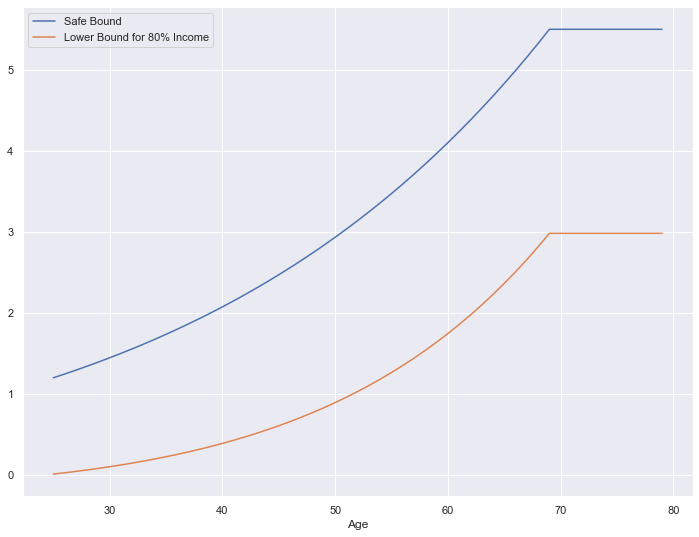

In [291]:
age_vec = np.arange(25,80)
plt.figure(figsize=(12,9))
plt.plot(age_vec,safe_vec,label='Safe Bound')
plt.plot(age_vec,wealth_vec*.95, label='Lower Bound for 80% Income')
plt.xlabel('Age')
plt.legend(loc='best')

In [233]:
inflation_smooth = np.ones(100) * 1.022
wealth_vec = np.ones(55) * 0.01
wage_vec = P1.init_wage * np.cumprod(inflation_smooth)
for i in range(44):
    wealth_vec[i+1] = wealth_vec[i]*1.055 + wage_vec[i]*0.15

safe_growth = 1.025
safe_vec = np.ones(55) * 5.5
for i in range(44):
    safe_vec[43-i] = (safe_vec[44-i] - wage_vec[43-i]*0.12) / safe_growth
print_person_result(P1, 1.065, 5.5, 132900*.15, name='1.csv')

In [228]:
P2 = PersonalRetirement(25, 69, 69, 'M', 200000, 0.8, n_simulation, life_table)
P2.wealth_comp(ir_mat, inf_mat, COLA_mat)
np.median(P1.wealth_needed), np.median(P2.wealth_needed)

(4.743221897275575, 5.924256511253864)

In [256]:
inflation_smooth = np.ones(100) * 1.022
wealth_vec = np.ones(55) * 0.01
wage_vec = P2.init_wage * np.cumprod(inflation_smooth)
for i in range(44):
    wealth_vec[i+1] = wealth_vec[i]*1.055 + wage_vec[i]*0.12

safe_growth = 1.025
safe_vec = np.ones(55) * 6.5
for i in range(44):
    safe_vec[43-i] = (safe_vec[44-i] - wage_vec[43-i]*0.12) / safe_growth
    
print_person_result(P2, 1.08, 7.5, 132900*.12, name='0.csv')

In [257]:
inflation_smooth = np.ones(100) * 1.022
wealth_vec = np.ones(55) * 0.01
wage_vec = P2.init_wage * np.cumprod(inflation_smooth)
for i in range(44):
    wealth_vec[i+1] = wealth_vec[i]*1.045 + wage_vec[i]*0.15

safe_growth = 1.025
safe_vec = np.ones(55) * 6.5
for i in range(44):
    safe_vec[43-i] = (safe_vec[44-i] - wage_vec[43-i]*0.12) / safe_growth
    
print_person_result(P2, 1.08, 7.5, 132900*.15, name='1.csv')

(array([ 124.,  916., 2511., 3001., 2090.,  975.,  288.,   73.,   16.,
           6.]),
 array([ 3.62123734,  4.28921166,  4.95718598,  5.62516031,  6.29313463,
         6.96110896,  7.62908328,  8.29705761,  8.96503193,  9.63300625,
        10.30098058]),
 <a list of 10 Patch objects>)

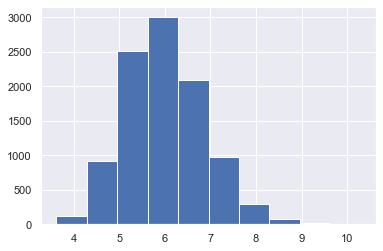

In [308]:
plt.hist(P2.wealth_needed)

## 5. A new update 8/1: list of objects

Reminder of person_simulation object:

    """
    Simulates the SS and 401(k) accounts for a person.
    
    Variables (Person):
        age: current age
        retire: retirement age, should not exceed 72
        full_retire: Full Retirement Age (FRA), the age at which 100% benefit is guaranteed
        sex: 'M' or 'F'
        init_wage: initial wage (in million dollars)
        
    Variables (Retirement):
        salary_proportion: The goal in terms of proportions
        savings: list of possible savings
        strategy_vec: currently available strategies...
        wealth_list: list of results for each strategy: len(strategy_vec) of "n_scenarios * len(savings)" arrays
        n_scenarios: number of scenarios
        survive_prob: survival probability, starting from retirement age
        wealth_needed: Goal in each
        
    Methods:
        wealth_comp: Compute wealth needed in each scenario
        risk_report: Outputs wealth needed, probability of reaching goal, GaR, CGaR
    """

In [353]:
def personal_retire_simulation(person, initial_amount, savings_rate, holdings, asset_return, hold_type='fixed'):
    """Simulates monthly data of a person for a certain number of years.
    
    asset_return should be total return, i.e. 1 plus the percentage return.
    if hold_type is "fixed" (by default), holdings is fixed mix with annual rebalance.
    if hold_type is a number, this is fixed mix with rebalance frequency (in months) .
    if hold_type is "SGP", a Bogle rule will be implemented.
    if hold_type is "dynamic", dynamic portfolio optimization will be conducted (to be implemented...)
    
    Other data required:
        inf_mat, ir_mat, COLA_mat: the macro variables simulated
        

    The simulation returns a full path of wealth at the end of each year, so it is a n_scenarios*n_years matrix.
    """
    n_months, n_assets, n_scenarios = asset_return.shape
    wealth_path = np.zeros((n_scenarios, int(n_months/12)))
    
    savings = savings_rate * person.init_wage

    if hold_type == 'fixed':
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
        return wealth_path

    elif type(hold_type)==int:
        ## Needs fix, perhaps not useful at all......
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%hold_type == 0: # Rebalance
                    asset_temp = np.sum(holdings_each)
                    holdings_each = asset_temp * holdings
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path

    elif hold_type == 'SGP':
        ## Gliding path: 90% equity at the beginning, and 46% of equity at the end
        ## Equity: assets 0, 1, 2, 6, 7; Bonds: assets 3, 4, 5, 8.
        if np.abs(np.sum(holdings[[0,1,2,6,7]])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                    holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
                    #if i == 7777: 
                    #Test:print([sum(holdings_each), holdings_each[0]])                    
        return wealth_path        

    elif hold_type == 'RGP':
        ## Gliding path: 36% equity at the beginning, and 80% of equity at the end
        ## Equity: assets 0, 1, 4; Bonds: assets 2, 3, 6, 7.
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (36 + (j+1)/12) / 36
                    holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (64 - (j+1)/12) / 64
                    #if i == 7777: 
                    #Test:print([sum(holdings_each), holdings_each[0]])                    
        return wealth_path 
    
    elif hold_type == 'Dynamic-GP':
        ## Gliding path, same as SGP but tries to catch up when falling behind
        ## Need another vector: standard path
        if np.abs(np.sum(holdings[[0,1,2,6,7]])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = 0.0
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec and wealth-vec
            n_years = person.retire-person.age-1
            wealth_vec = np.ones(55)*person.wealth_needed[i]
            wealth_growth = 1.06
            for n in range(n_years+1):
                wealth_vec[n_years-n] = (wealth_vec[n_years+1-n] - savings * inf_mat[i,n]) / wealth_growth
                
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    
                    if wealth_path[i,int(j/12)] >= wealth_vec[int(j/12)+1]:
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
                    else:
                        equity_prop = min((90 - (j+1)/12) + 20, 95)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10
                        n_flag = n_flag + 1
        return n_flag/n_scenarios, wealth_path
    
    elif hold_type == 'Safe-play':
        ## Gliding path, same as SGP but switches to bonds when safe
        ## Need another vector: safe vector
        if np.abs(np.sum(holdings[[0,1,2,6,7]])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = 0.0
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec and wealth-vec
            n_years = person.retire-person.age-1

            safe_growth = 1.025
            safe_vec = np.ones(55) * (person.wealth_needed[i]+0.5)
            for n in range(n_years+1):
                safe_vec[n_years-n] = (safe_vec[n_years+1-n] - savings * inf_mat[i,n]) / safe_growth
                
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings

                    if wealth_path[i,int(j/12)] <= safe_vec[int(j/12)+1]:
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
                    else:
                        equity_prop = max((90 - (j+1)/12) - 50, 5)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10
                        n_flag = n_flag + 1
        return n_flag/n_scenarios, wealth_path
    
    elif hold_type == 'Zone':
        ## Similar to the idea of 'No-Trade Zone', we have "No-change Zone"
        ## Need other vectors: standard path (wealth_vec) and safe play (safe_vec)
        if np.abs(np.sum(holdings[[0,1,2,6,7]])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = [0,0]
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec and wealth-vec
            n_years = person.retire-person.age-1
            wealth_vec = np.ones(55)*person.wealth_needed[i]
            wealth_growth = 1.06
            for n in range(n_years+1):
                wealth_vec[n_years-n] = (wealth_vec[n_years+1-n] - savings * inf_mat[i,n]) / wealth_growth

            safe_growth = 1.025
            safe_vec = np.ones(55) * (person.wealth_needed[i]+0.5)
            for n in range(n_years+1):
                safe_vec[n_years-n] = (safe_vec[n_years+1-n] - savings * inf_mat[i,n]) / safe_growth
            
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    
                    if wealth_path[i,int(j/12)] <= wealth_vec[int(j/12)+1]:
                        # lagging
                        equity_prop = min((90 - (j+1)/12) + 20, 95)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10
                        n_flag[0] = n_flag[0] + 1.0/n_scenarios
                        
                    elif wealth_path[i,int(j/12)] >= safe_vec[int(j/12)+1]:
                        equity_prop = max((90 - (j+1)/12) - 50, 5)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10 
                        n_flag[1] = n_flag[1] + 1.0/n_scenarios
                    else:
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
        return n_flag, wealth_path
 
    elif hold_type == 'ZoneSave':
        ## We save more (thus rebalancing the portfolio) when trailing
        ## Need other vectors: standard path (wealth_vec) and safe play (safe_vec)
        if np.abs(np.sum(holdings[[0,1,2,6,7]])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = [0,0]
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec and wealth-vec
            n_years = person.retire-person.age-1
            wealth_vec = np.ones(55)*person.wealth_needed[i]
            wealth_growth = 1.06
            for n in range(n_years+1):
                wealth_vec[n_years-n] = (wealth_vec[n_years+1-n] - savings * inf_mat[i,n]) / wealth_growth

            safe_growth = 1.025
            safe_vec = np.ones(55) * (person.wealth_needed[i]+0.5)
            for n in range(n_years+1):
                safe_vec[n_years-n] = (safe_vec[n_years+1-n] - savings * inf_mat[i,n]) / safe_growth
            
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                                      
                    if wealth_path[i,int(j/12)] <= wealth_vec[int(j/12)+1]:
                        # lagging
                        wealth_path[i,int(j/12)] = wealth_path[i,int(j/12)] + 0.03*savings/savings_rate*inf_mat[i,int(j/12)]
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        equity_prop = min((90 - (j+1)/12) + 15, 95)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10
                        n_flag[0] = n_flag[0] + 1.0/n_scenarios
                        
                    elif wealth_path[i,int(j/12)] >= safe_vec[int(j/12)+1]:
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        equity_prop = max((90 - (j+1)/12) - 50, 5)
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * equity_prop / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (100-equity_prop) / 10 
                        n_flag[1] = n_flag[1] + 1.0/n_scenarios
                    else:
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        holdings_each[[0,1,2,6,7]] = holdings_each[[0,1,2,6,7]] * (90 - (j+1)/12) / 90
                        holdings_each[[3,4,5,8]] = holdings_each[[3,4,5,8]] * (10 + (j+1)/12) / 10
        #print(safe_vec)
        #print(wealth_vec)
        return n_flag, wealth_path
    
    else:
        ## Buy and Hold...
        for i in range(n_scenarios):
            value =  initial_amount
            for j in range(n_months):
                value = value * np.sum(holdings * asset_return[j,:,i])
                if (j+1)%12==0:
                    value  = value + savings * inf_mat[i,int(j/12)]
                    wealth_path[i,int(j/12)] = value
        return wealth_path

In [617]:
###
# Probability Calculator: use 60-40 portfolio only

hold_vec_eq = np.array([0.4, 0.1, 0.2, 0.1, 0, 0.1, 0.1, 0, 0])

def prob_estimate_all(hold,R,retire_age=69, FRA=69, init_salary=132900,n_simulation=10000):
    results = np.zeros((4,8))
    for i in [0.6,0.7,0.8,0.9]: 
        P = PersonalRetirement(25, retire_age, FRA, 'F', init_salary, i, n_simulation, life_table)
        P.wealth_comp(ir_mat, inf_mat, COLA_mat)
        for j, s in enumerate(P.savings):
            saving_rate = int(s[:-1]) / 100.0
            results_temp = personal_retire_simulation(P, 0.01, saving_rate, hold, R[:,:,:n_simulation], 'fixed')
            results[int(i*10-5.99),j] = np.mean(P.wealth_needed<results_temp[:,43])
    return results
            
prob_est = prob_estimate_all(hold_vec_eq, r_all_cut+1)

In [379]:
pd_prob = pd.DataFrame(prob_est,index=['60%','70%','80%','90%'],columns=P1.savings)
pd_prob.to_csv('prob_eq.csv')

In [380]:
hold_vec_bonds = np.array([0, 0, 0, 0.3, 0.3, 0.3, 0, 0, 0.1])
prob_est2 = prob_estimate_all(hold_vec_bonds, r_all_cut+1)
pd_prob2 = pd.DataFrame(prob_est2,index=['60%','70%','80%','90%'],columns=P1.savings)
pd_prob2.to_csv('prob_bonds.csv')

In [373]:
def simulation_savings(filename,hold_vec,R,retire_age=69, FRA=69, saving_rate = 0.12, init_salary = 132900, n_simulation = 10000):
    """
    R: total return vector
    """
    title = 'save '+str(saving_rate*100)+'%'
    #np.array([title,'60-40','Bonds','Target Date','Dynamic-CatchUp','Dynamic-Safe','Dynamic-Zone','Dynamic-ZoneSave'])
    report = np.zeros((1,8))
    list_simulation = []
    
    list_people = []
    for i in [0.6,0.7,0.8,0.9]: 
        list_people.append(PersonalRetirement(25, retire_age, FRA, 'F', init_salary, i, n_simulation, life_table))
        

    for P in list_people:
        P.wealth_comp(ir_mat, inf_mat, COLA_mat)
        results_1 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[1,:], R[:,:,:n_simulation], 'fixed') 
        results_2 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[0,:], R[:,:,:n_simulation], 'fixed') 
        results_3 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'SGP')
        n_flag5,results_5 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Dynamic-GP')
        n_flag6,results_6 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Safe-play')
        n_flag7,results_7 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Zone') 
        n_flag8,results_8 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'ZoneSave')

        simu_list = [results_1,results_2,results_3,results_5,results_6,results_7,results_8]
        report_list = np.zeros((4,1))
        for r in simu_list:
            temp_amount = np.sort(P.wealth_needed-r[:,43])
            temp_arr = np.array([np.median(r[:,43]),np.mean(temp_amount<0), temp_amount[-499], np.mean(temp_amount[-499:])])
            report_list = np.hstack((report_list, temp_arr.reshape(4,1)))
        flag_list = np.array([P.salary_proportion,n_flag6/50,n_flag7[1]/50,n_flag8[1]/50,n_flag5/50,0,n_flag7[0]/50,n_flag8[0]/50])
    
        report = np.vstack((report,report_list,flag_list))
        list_simulation.append(simu_list)
    
    np.savetxt(filename, report, delimiter=",")
    return list_people, list_simulation

In [343]:
n_flag, results_test = personal_retire_simulation(P1, 0.01, 0.12, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'Zone')
np.mean(results_test[:,43]>P1.wealth_needed)

0.5489

In [348]:
n_flag, results_test = personal_retire_simulation(P1, 0.01, 0.12, hold_vec[2,:], r_all_cut[:,:,:n_simulation]+1, 'ZoneSave')
np.mean(results_test[:,43]>P1.wealth_needed),n_flag

[0.82416045 0.88361395 0.94375184 1.00483374 1.06634408 1.12824945
 1.19035785 1.2535716  1.31826472 1.38416335 1.45136162 1.52030335
 1.59076732 1.66179915 1.73406821 1.80774769 1.88227959 1.95778791
 2.03480132 2.11350402 2.19427165 2.27708389 2.36168075 2.44795556
 2.53581957 2.62530978 2.71614031 2.80867281 2.90273938 2.99818321
 3.09519886 3.19388234 3.29459934 3.39754226 3.50293147 3.61043539
 3.71960294 3.83066882 3.94427093 4.06036804 4.17932298 4.30097643
 4.42554039 4.5528715  4.68295227 4.68295227 4.68295227 4.68295227
 4.68295227 4.68295227 4.68295227 4.68295227 4.68295227 4.68295227
 4.68295227]
[-0.15364149 -0.12401049 -0.09340358 -0.06151969 -0.02882138  0.00469611
  0.03888003  0.07466764  0.11250154  0.15219364  0.19391944  0.2382123
  0.28496142  0.33332176  0.38404514  0.43741562  0.49299877  0.55103002
  0.61216053  0.67672284  0.74525623  0.81792706  0.89467244  0.97558558
  1.06078584  1.15052771  1.24475716  1.34407158  1.44856562  1.55835491
  1.67391728  1.7956

(0.6988, [17.87079999997169, 9.83819999999041])

In [356]:
n_flag5/50, n_flag6/50, n_flag7[0]/50, n_flag7[1]/50,n_flag8[0]/50,n_flag8[1]/50

(0.243042,
 0.20224599999999998,
 0.23770399999971278,
 0.22629199999973937,
 0.21182599999977308,
 0.2367999999997149)

In [357]:
simu_list0 = [results_10,results_20,results_30,results_50,results_60,results_70,results_80]
def print_retire_result(s_l, name='0.csv'):
    report_list = np.zeros((4,1))
    for r in s_l:
        temp_amount = np.sort(P1.wealth_needed-r[:,43])
        temp_arr = np.array([np.median(r[:,43]),np.mean(temp_amount<0), temp_amount[-499], np.mean(temp_amount[-499:])])
        report_list = np.hstack((report_list, temp_arr.reshape(4,1)))
    np.savetxt(name, report_list, delimiter=",")

print_retire_result(simu_list0, name='0802.csv')

In [374]:
# Working!!

hold_vec = np.array([[0, 0, 0, 0.3, 0.3, 0.3, 0, 0, 0.1], # Bonds
                    [0.4, 0.1, 0.2, 0.1, 0, 0.1, 0.1, 0, 0], # "60-40" - 80% equities in fact
                     [0.4, 0.1, 0.3, 0.05, 0, 0.05, 0.1, 0, 0]]) # SGP - 90% equity first

list_people, list_simulation = simulation_savings('result0803_1.csv',hold_vec,r_all_cut+1)

In [388]:
strats = ['60-40','Bonds','Target Date','Dynamic-CatchUp','Dynamic-Safe','Dynamic-Zone','Dynamic-ZoneSave']
results_random = np.zeros((5,7))

results_1 = pd.DataFrame(columns=strats, index=['Median Wealth', 'Probability', 'Goal-at-Risk', 
                                               'Conditional Goal-at-Risk', '% Falling Behind', '%Safe',' '])
results_1.iloc[:4,:] = np.zeros((4,7))
results_1.iloc[4,[3,5,6]] = [1,2,3]
results_1.iloc[5,[4,5,6]] = [2.3,2.4,2.5]
results_1.fillna('',inplace=True)
pd.DataFrame().append(results_1)

,60-40,Bonds,Target Date,Dynamic-CatchUp,Dynamic-Safe,Dynamic-Zone,Dynamic-ZoneSave
Median Wealth,0,0,0,0,0,0,0
Probability,0,0,0,0,0,0,0
Goal-at-Risk,0,0,0,0,0,0,0
Conditional Goal-at-Risk,0,0,0,0,0,0,0
% Falling Behind,,,,1,,2,3
%Safe,,,,,2.3,2.4,2.5
,,,,,,,


In [398]:
def simulation_savings(filename,hold_vec,R,retire_age=69, FRA=69, saving_rate = 0.12, init_salary = 132900, n_simulation = 10000):
    """
    R: total return vector
    """
    title = 'save '+str(saving_rate*100)+'%'
    strats=['60-40','Bonds','Target Date','Dynamic-CatchUp','Dynamic-Safe','Dynamic-Zone','Dynamic-ZoneSave']
    report = pd.DataFrame()
    h = int(n_simulation * 0.05-1)
    list_simulation = []
    
    list_people = []
    for i in [0.6,0.7,0.8,0.9]: 
        list_people.append(PersonalRetirement(25, retire_age, FRA, 'F', init_salary, i, n_simulation, life_table))     

    for P in list_people:
        P.wealth_comp(ir_mat, inf_mat, COLA_mat)
        results_1 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[1,:], R[:,:,:n_simulation], 'fixed') 
        results_2 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[0,:], R[:,:,:n_simulation], 'fixed') 
        results_3 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'SGP')
        n_flag5,results_5 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Dynamic-GP')
        n_flag6,results_6 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Safe-play')
        n_flag7,results_7 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Zone') 
        n_flag8,results_8 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'ZoneSave')

        simu_list = [results_1,results_2,results_3,results_5,results_6,results_7,results_8]
        
        report_list = pd.DataFrame(columns=strats, index=['Median Wealth', 'Probability', 'Goal-at-Risk', 
                                               'Conditional Goal-at-Risk', '% Falling Behind', '%Safe',' '])
        for j, r in enumerate(simu_list):
            temp_amount = np.sort(P.wealth_needed-r[:,43])
            temp_arr = np.array([np.median(r[:,43]),np.mean(temp_amount<0), temp_amount[-h], np.mean(temp_amount[-h:])])          
            report_list.iloc[:4,j] = temp_arr
        
        report_list.iloc[4,[3,5,6]] = [n_flag5/50,n_flag7[0]/50,n_flag8[0]/50]
        report_list.iloc[5,[4,5,6]] = [n_flag6/50,n_flag7[1]/50,n_flag8[1]/50]
        report_list.fillna('',inplace=True)
        report = report.append(report_list)
        list_simulation.append(simu_list)
    
    report.to_csv(filename)
    return list_people, list_simulation

In [400]:
list_test, list_test1 = simulation_savings('result0806.csv',hold_vec,r_all_cut+1,n_simulation=10000)

In [404]:
list_p1, list_s1, report1 = simulation_savings_sept(hold_vec,r_all_cut+1,n_simulation=10000)
list_p2, list_s2, report2 = simulation_savings_sept(hold_vec,r_all_cut+1,saving_rate=0.13,n_simulation=10000)

report1.to_csv('report0813_1.csv')
report2.to_csv('report0813_2.csv')

## Work: 8/15 - 9/2...
1. Add: total amount saved: "Do we simply move money from one account to another?"

2. Compare RGP and RGP-zone, RGP-save


In [429]:
def personal_retire_simulation_new(person, initial_amount, savings_rate, holdings, asset_return, 
                                   hold_type='fixed', sl=-1.0):
    """Simulates monthly data of a person for a certain number of years.
    
    Assets: US equity, developed, emerging, US Treasuries, corp bonds, TIPS, Real Estate, Commodities, T-bill
    Equity (Y/N): Y      Y          Y             N            N        N        Y             (Y)        N
    
    asset_return should be total return, i.e. 1 plus the percentage return.
    if hold_type is "fixed" (by default), holdings is fixed mix with annual rebalance.
    if hold_type is a number, this is fixed mix with rebalance frequency (in months) .
    if hold_type is "SGP", a Bogle rule will be implemented.
    if hold_type is "RGP", a reversed glide path (RGP) will be implemented.
    if hold_type is "dynamic", dynamic portfolio optimization will be conducted.
    
    sl is the slope for glide path (SGP: -1, RGP: 1.5)
    
    Other data required:
        inf_mat, ir_mat, COLA_mat: the macro variables simulated
        
    The simulation returns a full path of wealth at the end of each year, so it is a n_scenarios*n_years matrix.
    """
    n_months, n_assets, n_scenarios = asset_return.shape
    wealth_path = np.zeros((n_scenarios, int(n_months/12)))
    eq_set = [0,1,2,6,7]
    bd_set = [3,4,5,8]
    equity_prop = np.sum(holdings[eq_set]) * 100
    
    savings = savings_rate * person.init_wage
    total_saved = initial_amount

    if hold_type == 'fixed':
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
        return wealth_path

    elif type(hold_type)==int:
        ## this integer is rebalance frequency
        for i in range(n_scenarios):
            holdings_each = holdings
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if j%hold_type == 0: # Rebalance
                    asset_temp = np.sum(holdings_each)
                    holdings_each = asset_temp * holdings
                if j%12==0:
                    holdings_each = holdings_each * (1-spending_rate)
                    wealth_path[i,int(j/12)] = np.sum(holdings_each)
        return wealth_path

    elif hold_type == 'SGP':
        ## Gliding path: slope is given
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    holdings_each[eq_set] = holdings_each[eq_set] * (equity_prop + sl*(j+1)/12) / equity_prop
                    holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_prop - sl*(j+1)/12) / (100-equity_prop)                
        return wealth_path

    elif hold_type == 'RGP':
        ## Gliding path: reversed
        if np.abs(np.sum(holdings[eq_set])-0.25) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    holdings_each[eq_set] = holdings_each[eq_set] * (equity_prop + sl*(j+1)/12) / equity_prop
                    holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_prop - sl*(j+1)/12) / (100-equity_prop) 
                    #if i == 7777: 
                    #Test:print([sum(holdings_each), holdings_each[0]])                    
        return wealth_path 
    
    elif hold_type == 'Dynamic-GP':
        ## Gliding path, same as SGP but tries to catch up when falling behind
        
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = 0.0
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute wealth-vec
            n_years = person.retire-person.age-1
            wealth_vec = np.ones(55)*person.wealth_needed[i]
            wealth_growth = 1.06
            for n in range(n_years+1):
                wealth_vec[n_years-n] = (wealth_vec[n_years+1-n] - savings * inf_mat[i,n]) / wealth_growth
                
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    
                    if wealth_path[i,int(j/12)] >= wealth_vec[int(j/12)+1]:
                        equity_newprop = equity_prop + sl*(j+1)/12
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                    else:
                        equity_newprop = min(equity_prop + sl*(j+1)/12 + 20, 95)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag = n_flag + 1
        return n_flag/n_scenarios, wealth_path
    
    elif hold_type == 'Safe-play':
        ## Gliding path, same as SGP but switches to bonds when safe
                                             
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = 0.0
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec
            n_years = person.retire-person.age-1

            safe_growth = 1.025
            safe_vec = np.ones(55) * (person.wealth_needed[i]+0.5)
            for n in range(n_years+1):
                safe_vec[n_years-n] = (safe_vec[n_years+1-n] - savings * inf_mat[i,n]) / safe_growth
                
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings

                    if wealth_path[i,int(j/12)] <= safe_vec[int(j/12)+1]:
                        equity_newprop = equity_prop + sl*(j+1)/12
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                    else:
                        equity_newprop = max(equity_prop + sl*(j+1)/12 - 50, 5)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag = n_flag + 1
        return n_flag/n_scenarios, wealth_path
    
    elif hold_type == 'Zone':
        ## Similar to the idea of 'No-Trade Zone', we have "No-change Zone"
        ## Works for both SGP-zone and RGP-zone
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001 and np.abs(np.sum(holdings[eq_set])-0.25) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = [0,0]
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec and wealth-vec
            n_years = person.retire-person.age-1
            wealth_vec = np.ones(55)*person.wealth_needed[i]
            wealth_growth = 1.06
            for n in range(n_years+1):
                wealth_vec[n_years-n] = (wealth_vec[n_years+1-n] - savings * inf_mat[i,n]) / wealth_growth

            safe_growth = 1.025
            safe_vec = np.ones(55) * (person.wealth_needed[i]+0.5)
            for n in range(n_years+1):
                safe_vec[n_years-n] = (safe_vec[n_years+1-n] - savings * inf_mat[i,n]) / safe_growth
            
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                    holdings_each = wealth_path[i,int(j/12)] * holdings
                    
                    if wealth_path[i,int(j/12)] <= wealth_vec[int(j/12)+1]:
                        # lagging
                        equity_newprop = min(equity_prop + sl*(j+1)/12 +20, 95)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag[0] = n_flag[0] + 1.0/n_scenarios
                        
                    elif wealth_path[i,int(j/12)] >= safe_vec[int(j/12)+1]:
                        equity_newprop = max(equity_prop + sl*(j+1)/12 -50, 5)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag[1] = n_flag[1] + 1.0/n_scenarios
                    else:
                        equity_newprop = equity_prop + sl*(j+1)/12
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
        return n_flag, wealth_path
 
    elif hold_type == 'ZoneSave':
        ## We save more (thus rebalancing the portfolio) when trailing
        ## Works for both SGP and RGP
        if np.abs(np.sum(holdings[eq_set])-0.9) > 0.001 and np.abs(np.sum(holdings[eq_set])-0.25) > 0.001:
            print('Initial Holding Incorrect. Results may be affected.')
        n_flag = [0,0]
        
        for i in range(n_scenarios):
            holdings_each = holdings * initial_amount
            
            # Compute safe-vec and wealth-vec
            n_years = person.retire-person.age-1
            wealth_vec = np.ones(55)*person.wealth_needed[i]
            wealth_growth = 1.06
            for n in range(n_years+1):
                wealth_vec[n_years-n] = (wealth_vec[n_years+1-n] - savings * inf_mat[i,n]) / wealth_growth

            safe_growth = 1.025
            safe_vec = np.ones(55) * (person.wealth_needed[i]+0.5)
            for n in range(n_years+1):
                safe_vec[n_years-n] = (safe_vec[n_years+1-n] - savings * inf_mat[i,n]) / safe_growth
            
            for j in range(n_months):
                holdings_each = holdings_each * asset_return[j,:,i]
                if (j+1)%12==0:
                    wealth_path[i,int(j/12)] = np.sum(holdings_each) + savings * inf_mat[i,int(j/12)]
                                      
                    if wealth_path[i,int(j/12)] <= wealth_vec[int(j/12)+1]:
                        # lagging
                        wealth_path[i,int(j/12)] = wealth_path[i,int(j/12)] + 0.03*savings/savings_rate*inf_mat[i,int(j/12)]
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        equity_newprop = min(equity_prop + sl*(j+1)/12 +20, 95)
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag[0] = n_flag[0] + 1.0/n_scenarios
                        
                    elif wealth_path[i,int(j/12)] >= safe_vec[int(j/12)+1]:
                        equity_newprop = max(equity_prop + sl*(j+1)/12 -50, 5)
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
                        n_flag[1] = n_flag[1] + 1.0/n_scenarios
                    else:
                        equity_newprop = equity_prop + sl*(j+1)/12
                        holdings_each = wealth_path[i,int(j/12)] * holdings
                        holdings_each[eq_set] = holdings_each[eq_set] * equity_newprop / equity_prop
                        holdings_each[bd_set] = holdings_each[bd_set] * (100 - equity_newprop) / (100-equity_prop) 
        #print(safe_vec)
        #print(wealth_vec)
        return n_flag, wealth_path
    
    else:
        ## Buy and Hold...
        for i in range(n_scenarios):
            value =  initial_amount
            for j in range(n_months):
                value = value * np.sum(holdings * asset_return[j,:,i])
                if (j+1)%12==0:
                    value  = value + savings * inf_mat[i,int(j/12)]
                    wealth_path[i,int(j/12)] = value
        return wealth_path

In [435]:
def simulation_savings_sept(hold_vec,R,retire_age=69, FRA=69, saving_rate = 0.12, init_salary = 132900, n_simulation = 10000):
    """
    R: total return vector
    """
    title = 'save '+str(saving_rate*100)+'%'
    strats=['60-40','Bonds','Target Date','Reversed Glide Path','Dynamic-CatchUp','Dynamic-Safe',
            'Dynamic-Zone','Dynamic-ZoneSave','Reversed-Zone','Reversed-ZoneSave']
    report = pd.DataFrame()
    h = int(n_simulation * 0.05-1)
    list_simulation = []
    
    list_people = []
    for i in [0.6,0.7,0.8,0.9]: 
        list_people.append(PersonalRetirement(25, retire_age, FRA, 'F', init_salary, i, n_simulation, life_table))     

    for P in list_people:
        P.wealth_comp(ir_mat, inf_mat, COLA_mat)
        results_1 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[1,:], R[:,:,:n_simulation], 'fixed') 
        results_2 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[0,:], R[:,:,:n_simulation], 'fixed') 
        results_3 = personal_retire_simulation_new(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'SGP')
        results_4 = personal_retire_simulation_new(P, 0.01, saving_rate, hold_vec[3,:], R[:,:,:n_simulation], 'RGP', sl=1.5)
        n_flag5,results_5 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Dynamic-GP')
        n_flag6,results_6 = personal_retire_simulation(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Safe-play')
        n_flag7,results_7 = personal_retire_simulation_new(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'Zone') 
        n_flag8,results_8 = personal_retire_simulation_new(P, 0.01, saving_rate, hold_vec[2,:], R[:,:,:n_simulation], 'ZoneSave')
        n_flag9,results_9 = personal_retire_simulation_new(P, 0.01, saving_rate, hold_vec[3,:], 
                                                           R[:,:,:n_simulation], 'Zone', sl=1.5) 
        n_flag10,results_10 = personal_retire_simulation_new(P, 0.01, saving_rate, hold_vec[3,:], 
                                                             R[:,:,:n_simulation], 'ZoneSave',sl=1.5)

        simu_list = [results_1,results_2,results_3,results_4,results_5,results_6,results_7,results_8,results_9,results_10]
        
        report_list = pd.DataFrame(columns=strats, index=['Median Wealth', 'Probability', 'Goal-at-Risk', 
                                               'Conditional Goal-at-Risk', '% Falling Behind', '%Safe',' '])
        for j, r in enumerate(simu_list):
            temp_amount = np.sort(P.wealth_needed-r[:,43])
            temp_arr = np.array([np.median(r[:,43]),np.mean(temp_amount<0), temp_amount[-h], np.mean(temp_amount[-h:])])          
            report_list.iloc[:4,j] = temp_arr
        
        report_list.iloc[4,[4,6,7,8,9]] = [n_flag5/50,n_flag7[0]/50,n_flag8[0]/50,n_flag9[0]/50,n_flag10[0]/50]
        report_list.iloc[5,[5,6,7,8,9]] = [n_flag6/50,n_flag7[1]/50,n_flag8[1]/50,n_flag9[1]/50,n_flag10[1]/50]
        report_list.fillna('',inplace=True)
        report = report.append(report_list)
        list_simulation.append(simu_list)

    return list_people, list_simulation, report

In [408]:
# Print asset return
for i in range(9):
    ann_temp = (np.cumprod(1+r_all_cut[:,i,:],axis=0)[-1,:]) ** (1/50)
    print(assetname[i]+': ',ann_temp.mean(),ann_temp.std())

US Equities:  1.065275538021011 0.011319818838214273
EAFE Equities:  1.050813772212351 0.01910111695115402
EM Equities:  1.055372772710317 0.02650947837634803
Long Treasuries:  1.033497803394401 0.006566829721970086
Corp Bonds:  1.0510694687089062 0.007443573087236374
TIPS:  1.0383301524644455 0.008591565243483413
Real Estate:  1.0538071516420842 0.02562805162847877
Commodities:  1.029449645286481 0.030037657769141406
T-bill:  1.0242476890692886 0.001031149151126838


In [425]:
# New test - Aug 15
hold_vec = np.array([[0, 0, 0, 0.3, 0.3, 0.3, 0, 0, 0.1], # Bonds
                    [0.4, 0.1, 0.2, 0.1, 0, 0.1, 0.1, 0, 0], # "60-40" - 80% equities in fact
                     [0.4, 0.1, 0.3, 0.05, 0, 0.05, 0.1, 0, 0], # SGP - 90% equity first
                    [0.15, 0.025, 0.05, 0.25, 0, 0.5, 0.025, 0, 0]]) # RGP - 25% equity first, 90% equity last

In [439]:
list_p2, list_s2, report_new2 = simulation_savings_sept(hold_vec,r_all_cut+1,saving_rate=0.13,init_salary=132900)
report_new2.to_csv('report0815_s13w13.csv')

In [440]:
list_p3, list_s3, report_new3 = simulation_savings_sept(hold_vec,r_all_cut+1,saving_rate=0.10,init_salary=132900)

In [441]:
report_new3.to_csv('report0815_s10w13.csv')

In [442]:
list_p4, list_s4, report_new4 = simulation_savings_sept(hold_vec,r_all_cut+1,saving_rate=0.12,init_salary=200000)
report_new4.to_csv('report0815_s10w20.csv')

In [443]:
list_p5, list_s5, report_new5 = simulation_savings_sept(hold_vec,r_all_cut+1,saving_rate=0.15,init_salary=200000)
report_new5.to_csv('report0815_s15w20.csv')

In [454]:
print([np.mean(P.wealth_needed) for P in list_p3])
print([np.mean(P.wealth_needed) for P in list_p4])
print([np.mean(P.wealth_needed) for P in list_p5]) # Same!

[2.542251940296272, 3.29602660887306, 4.0498012774498475, 4.803575946026634]
[4.825695744427309, 5.960044380359268, 7.094393016291229, 8.22874165222319]
[4.825695744427309, 5.960044380359268, 7.094393016291229, 8.22874165222319]


(array([  4.,   5.,   8.,  11.,  19.,  23.,  35.,  59.,  59., 104., 111.,
        114., 108.,  80.,  79.,  56.,  40.,  29.,  27.,  14.,   8.,   5.,
          1.,   0.,   1.]),
 array([-0.09784183, -0.08860222, -0.07936262, -0.07012301, -0.0608834 ,
        -0.05164379, -0.04240419, -0.03316458, -0.02392497, -0.01468536,
        -0.00544576,  0.00379385,  0.01303346,  0.02227307,  0.03151267,
         0.04075228,  0.04999189,  0.0592315 ,  0.06847111,  0.07771071,
         0.08695032,  0.09618993,  0.10542954,  0.11466914,  0.12390875,
         0.13314836]),
 <a list of 25 Patch objects>)

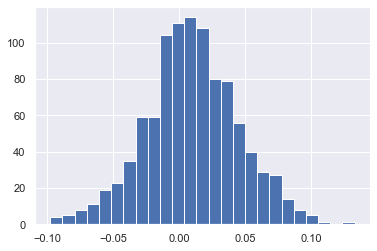

In [463]:
plt.hist(r_all_cut[0,0,:1000],bins=25)

### Feels repetitive? There is a new class at the end of section 3...

Feel free to continue work on that section, instead of this.